<a href="https://colab.research.google.com/github/RoyAru11/Finance-/blob/main/Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


--- Selected In-sample and OOS stats (annual) ---
GMV (short): in r=0.2423, var=0.010529 | OOS mean=0.2973, vol=0.1229
GMV (long):  in r=0.2260, var=0.010741 | OOS mean=0.3167, vol=0.1248
Tangency (short): in r=0.6599, var=0.032259 | OOS mean=0.3834, vol=0.2196
Mid target closed (short): in r=0.1877, var=0.010901 | OOS mean=0.2860, vol=0.1195
Mid target long: in r=0.1877, var=0.010983 | OOS mean=0.2994, vol=0.1208
Σ^(-1)μ portfolio: in r=0.5910, var=0.025677 | OOS mean=0.3692, vol=0.1987


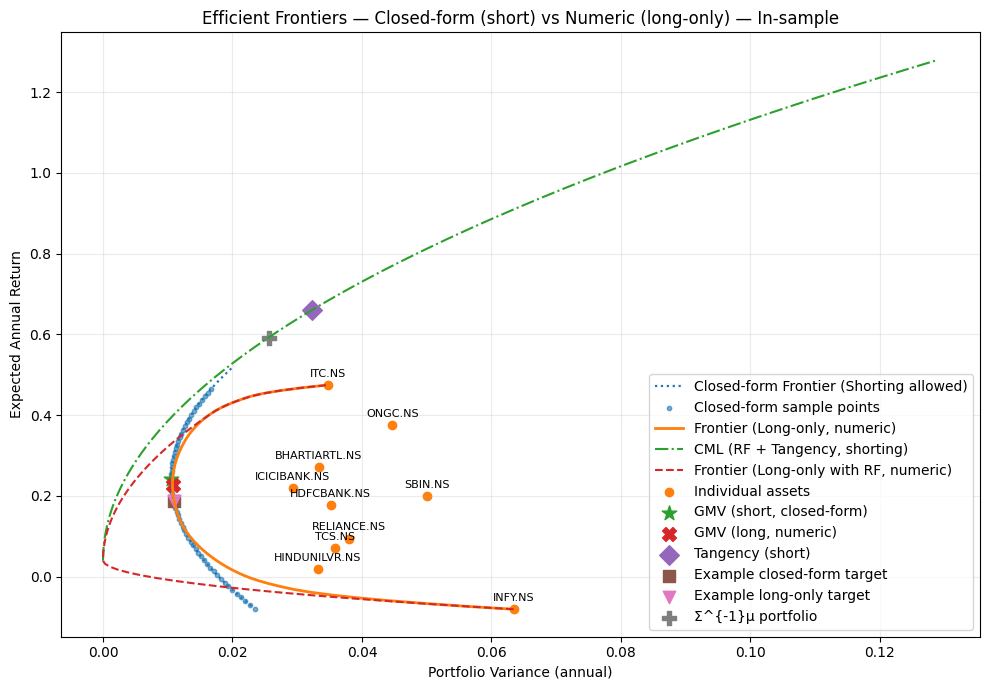


GMV (short) (top weights):
 TCS.NS           0.2150
BHARTIARTL.NS    0.1757
HINDUNILVR.NS    0.1731
ITC.NS           0.1496
ONGC.NS          0.1490
HDFCBANK.NS      0.1220
ICICIBANK.NS     0.1154
RELIANCE.NS      0.0136
SBIN.NS         -0.0281
INFY.NS         -0.0854
Name: GMV (short), dtype: float64
Sum = 1.0

GMV (long-only) (top weights):
 HINDUNILVR.NS    0.1813
BHARTIARTL.NS    0.1740
ONGC.NS          0.1554
ITC.NS           0.1423
TCS.NS           0.1410
HDFCBANK.NS      0.1083
ICICIBANK.NS     0.0912
RELIANCE.NS      0.0065
INFY.NS          0.0000
SBIN.NS          0.0000
Name: GMV (long-only), dtype: float64
Sum = 1.0

Tangency (short) (top weights):
 ITC.NS           0.8029
ONGC.NS          0.3750
BHARTIARTL.NS    0.3020
TCS.NS           0.2789
HDFCBANK.NS      0.2075
ICICIBANK.NS     0.1914
SBIN.NS         -0.1544
HINDUNILVR.NS   -0.3159
INFY.NS         -0.3403
RELIANCE.NS     -0.3470
Name: Tangency (short), dtype: float64
Sum = 1.0

Σ^{-1}μ (top weights):
 ITC.NS           0

In [ ]:

# markowitz_closed_form_and_numeric_fixed.py
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------
# USER SETTINGS
# -------------------------
# >>> TICKERS: replace this list with the stocks you want to use.
# You can mix NSE tickers (end with .NS). Example below uses 10 NIFTY names.
TICKERS = [
    "RELIANCE.NS","TCS.NS","HDFCBANK.NS","INFY.NS","ICICIBANK.NS",
    "ITC.NS","SBIN.NS","BHARTIARTL.NS","HINDUNILVR.NS","ONGC.NS"
]
TRADING_DAYS = 252
RISK_FREE_ANN = 0.04   # annual risk-free rate (cases 3 & 4)
N_FRONTIER = 80
X_AXIS = "variance"    # choose: "variance" or "stdev"

# -------------------------
# DATE WINDOWS
# 2 years (train) -> next 1 year (test). Adjust as needed.
# -------------------------
train_start = "2022-08-01"
train_end   = "2023-08-01"
test_start  = "2023-08-01"
test_end    = "2024-08-01"

# -------------------------
# 1) Download prices
# -------------------------
p_train = yf.download(TICKERS, start=train_start, end=train_end, progress=False, auto_adjust=False)["Adj Close"]
p_test  = yf.download(TICKERS, start=test_start,  end=test_end,  progress=False, auto_adjust=False)["Adj Close"]

# Keep only tickers present in both
common = sorted(list(set(p_train.columns) & set(p_test.columns)))
if len(common) < len(TICKERS):
    print("Warning: dropping tickers missing in train/test ->", set(TICKERS) - set(common))
p_train = p_train[common].dropna(how="all")
p_test  = p_test[common].dropna(how="all")
tickers = common
N = len(tickers)
assert N >= 2, "Need at least 2 assets."

# compute daily returns
rets_train = p_train.pct_change().dropna()
rets_test  = p_test.pct_change().dropna()

# -------------------------
# 2) Estimate mu and Sigma (annualized)
# -------------------------
mu_daily = rets_train.mean().values     # daily mean vector
mu_ann   = mu_daily * TRADING_DAYS      # annualized expected returns (vector)
Sigma_daily = rets_train.cov().values
Sigma_ann   = Sigma_daily * TRADING_DAYS

# robust inverse (use pinv if singular)
try:
    Sigma_inv = np.linalg.inv(Sigma_ann)
except np.linalg.LinAlgError:
    Sigma_inv = np.linalg.pinv(Sigma_ann)

ones = np.ones(N)

# Closed-form constants (shorting allowed)
A = ones @ Sigma_inv @ ones
B = ones @ Sigma_inv @ mu_ann
C = mu_ann @ Sigma_inv @ mu_ann
D = A * C - B**2
if D <= 0:
    print("Warning: D <= 0 (problematic).")

# -------------------------
# 3) Closed-form weights (shorting allowed)
# -------------------------
def w_for_target_short(r_target):
    """Closed-form weights for unconstrained (shorting allowed) target return r_target (annual)."""
    coeff1 = (C - B * r_target) / D
    coeff2 = (A * r_target - B) / D
    w = Sigma_inv @ (coeff1 * ones + coeff2 * mu_ann)
    return w

def w_gmv_short():
    """Global minimum variance (shorting allowed)"""
    return (Sigma_inv @ ones) / (ones @ Sigma_inv @ ones)

def w_tangency_short(rf_annual=RISK_FREE_ANN):
    """Tangency (maximum Sharpe) portfolio (shorting allowed), normalized to sum=1."""
    x = Sigma_inv @ (mu_ann - rf_annual * ones)
    denom = ones @ x
    return x / denom

# closed-form frontier (variance as function of return r)
def closed_form_variance(r_grid):
    # sigma^2(r) = (A r^2 - 2 B r + C) / D
    return (A * r_grid**2 - 2.0 * B * r_grid + C) / D

# -------------------------
# 4) Numeric solver for long-only (no shorting)
#     Solve min variance s.t. sum(w)=1 and w'*mu = r
# -------------------------
def get_frontier_numeric(mu_vec, Sigma_mat, allow_short=True, n_points=N_FRONTIER):
    r_min = float(np.min(mu_vec))
    r_max = float(np.max(mu_vec))
    r_grid = np.linspace(r_min + 1e-6, r_max - 1e-6, n_points)

    weights_list, vars_list, rets_list = [], [], []
    bounds = None if allow_short else tuple((0, 1) for _ in range(len(mu_vec)))
    for r_t in r_grid:
        cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},
            {'type': 'eq', 'fun': (lambda w, target=r_t, mu=mu_vec: float(np.dot(w, mu) - target))}
        ]
        x0 = np.ones(len(mu_vec)) / len(mu_vec)
        res = minimize(lambda w: float(w.T @ Sigma_mat @ w), x0, method='SLSQP',
                       bounds=bounds, constraints=cons,
                       options={'ftol':1e-12, 'maxiter':2000})
        if res.success:
            w = res.x
            weights_list.append(w)
            vars_list.append(float(w.T @ Sigma_mat @ w))
            rets_list.append(float(w.T @ mu_vec))
    return {
        'weights': np.array(weights_list),
        'vars': np.array(vars_list),
        'rets': np.array(rets_list),
    }

# -------------------------
# 5) Build the 4 cases
# -------------------------

# CASE 1: n assets, shorting allowed -> closed-form frontier
r_grid_short = np.linspace(np.min(mu_ann)*0.9, np.max(mu_ann)*1.1, 300)
vars_closed = closed_form_variance(r_grid_short)
# coarser grid for OOS eval
targets_coarse = np.linspace(np.min(mu_ann)*0.98, np.max(mu_ann)*0.98, 60)
W_closed = np.vstack([w_for_target_short(r) for r in targets_coarse])
vars_closed_coarse = np.einsum('ij,jk,ik->i', W_closed, Sigma_ann, W_closed)
rets_closed_coarse = W_closed @ mu_ann

# CASE 2: n assets, no shorting -> numeric frontier
frontier_long = get_frontier_numeric(mu_ann, Sigma_ann, allow_short=False, n_points=N_FRONTIER)
W_long = frontier_long['weights']
vars_long = frontier_long['vars']
rets_long = frontier_long['rets']

# CASE 3: n risky + 1 risk-free, shorting allowed
w_tan = w_tangency_short(RISK_FREE_ANN)  # weights on risky assets (sum to 1)
mu_tan = float(w_tan @ mu_ann)
sigma_tan = np.sqrt(float(w_tan @ Sigma_ann @ w_tan))
sigs = np.linspace(0, sigma_tan*2.0, 200)
r_cml = RISK_FREE_ANN + (mu_tan - RISK_FREE_ANN) / sigma_tan * sigs

# CASE 4: n risky + 1 risk-free, no shorting (add RF as zero-variance asset)
mu_aug = np.concatenate([mu_ann, [RISK_FREE_ANN]])
Sigma_aug = np.zeros((N+1, N+1))
Sigma_aug[:N,:N] = Sigma_ann

def get_frontier_numeric_with_rf(mu_vec, Sigma_mat, allow_short=False, n_points=N_FRONTIER):
    n = len(mu_vec)
    r_min = float(np.min(mu_vec)) + 1e-8
    r_max = float(np.max(mu_vec)) - 1e-8
    r_grid = np.linspace(r_min, r_max, n_points)
    weights_list, vars_list, rets_list = [], [], []
    bounds = None if allow_short else tuple((0,1) for _ in range(n))
    for r_t in r_grid:
        cons = [
            {'type':'eq','fun': lambda w: np.sum(w) - 1.0},
            {'type':'eq','fun': lambda w, target=r_t, mu=mu_vec: float(np.dot(w, mu) - target)}
        ]
        x0 = np.ones(n) / n
        res = minimize(lambda w: float(w.T @ Sigma_mat @ w), x0, method='SLSQP',
                       bounds=bounds, constraints=cons,
                       options={'ftol':1e-12, 'maxiter':2000})
        if res.success:
            weights_list.append(res.x)
            vars_list.append(float(res.x.T @ Sigma_mat @ res.x))
            rets_list.append(float(res.x @ mu_vec))
    return {'weights':np.array(weights_list), 'vars':np.array(vars_list), 'rets':np.array(rets_list)}

frontier_long_with_rf = get_frontier_numeric_with_rf(mu_aug, Sigma_aug, allow_short=False, n_points=N_FRONTIER)
W_long_rf = frontier_long_with_rf['weights']   # shape (m, N+1) (last col is RF)
vars_long_rf = frontier_long_with_rf['vars']
rets_long_rf = frontier_long_with_rf['rets']

# -------------------------
# 6) Evaluate in-sample (train) & out-of-sample (test)
# -------------------------
def evaluate_oos(w_risky, rets_test):
    daily = rets_test.values @ w_risky
    mean_ann = daily.mean() * TRADING_DAYS
    vol_ann = daily.std(ddof=1) * np.sqrt(TRADING_DAYS)
    return mean_ann, vol_ann

# GMV short
w_gmv_s = w_gmv_short()
r_gmv_s = float(w_gmv_s @ mu_ann)
v_gmv_s = float(w_gmv_s @ Sigma_ann @ w_gmv_s)

# GMV long: numeric solution (min variance s.t. sum=1, w>=0)
cons_gmv = ({'type':'eq','fun': lambda x: np.sum(x) - 1.0},)
bounds_long = tuple((0,1) for _ in range(N))
x0 = np.ones(N)/N
res = minimize(lambda w: float(w.T @ Sigma_ann @ w), x0, method='SLSQP', bounds=bounds_long, constraints=cons_gmv)
if res.success:
    w_gmv_long = res.x
    r_gmv_l = float(w_gmv_long @ mu_ann)
    v_gmv_l = float(w_gmv_long @ Sigma_ann @ w_gmv_long)
else:
    w_gmv_long = None
    r_gmv_l = np.nan; v_gmv_l = np.nan

# Tangency short
w_tan_s = w_tan
r_tan_s = float(w_tan_s @ mu_ann)
v_tan_s = float(w_tan_s @ Sigma_ann @ w_tan_s)

# pick a mid target and get closed form & numeric long-only target
mid_target = float(np.median(mu_ann))
w_target_closed = w_for_target_short(mid_target)
r_target_closed = float(w_target_closed @ mu_ann)
v_target_closed = float(w_target_closed @ Sigma_ann @ w_target_closed)

# numeric long-only target: equality target = mid_target
cons_target_long = [
    {'type':'eq','fun': lambda w: np.sum(w) - 1.0},
    {'type':'eq','fun': lambda w, t=mid_target: float(w @ mu_ann - t)}
]
res_target_long = minimize(lambda w: float(w.T @ Sigma_ann @ w),
                           np.ones(N)/N, method='SLSQP', bounds=bounds_long, constraints=cons_target_long,
                           options={'ftol':1e-12, 'maxiter':2000})
if res_target_long.success:
    w_target_long = res_target_long.x
    r_target_long = float(w_target_long @ mu_ann)
    v_target_long = float(w_target_long @ Sigma_ann @ w_target_long)
else:
    w_target_long = None
    r_target_long = np.nan; v_target_long = np.nan

# Simple covariance-weighted (Σ^{-1} μ) portfolio (normalized to sum 1)
def w_covariance(mu, Sigma):
    inv_S = np.linalg.pinv(Sigma)
    w = inv_S @ mu
    w /= np.ones(len(mu)) @ w
    return w
w_cov = w_covariance(mu_ann, Sigma_ann)
r_cov = float(mu_ann @ w_cov)
v_cov = float(w_cov @ Sigma_ann @ w_cov)

# OOS evaluation (using risky-asset weights only)
oos_mean_gmv_s, oos_vol_gmv_s = evaluate_oos(w_gmv_s, rets_test)
oos_mean_gmv_l, oos_vol_gmv_l = evaluate_oos(w_gmv_long, rets_test) if w_gmv_long is not None else (np.nan, np.nan)
oos_mean_tan_s, oos_vol_tan_s = evaluate_oos(w_tan_s, rets_test)
oos_mean_target_closed, oos_vol_target_closed = evaluate_oos(w_target_closed, rets_test)
oos_mean_target_long, oos_vol_target_long = evaluate_oos(w_target_long, rets_test) if w_target_long is not None else (np.nan, np.nan)
oos_mean_cov, oos_vol_cov = evaluate_oos(w_cov, rets_test)

print("\n--- Selected In-sample and OOS stats (annual) ---")
print(f"GMV (short): in r={r_gmv_s:.4f}, var={v_gmv_s:.6f} | OOS mean={oos_mean_gmv_s:.4f}, vol={oos_vol_gmv_s:.4f}")
print(f"GMV (long):  in r={r_gmv_l:.4f}, var={v_gmv_l:.6f} | OOS mean={oos_mean_gmv_l:.4f}, vol={oos_vol_gmv_l:.4f}")
print(f"Tangency (short): in r={r_tan_s:.4f}, var={v_tan_s:.6f} | OOS mean={oos_mean_tan_s:.4f}, vol={oos_vol_tan_s:.4f}")
print(f"Mid target closed (short): in r={r_target_closed:.4f}, var={v_target_closed:.6f} | OOS mean={oos_mean_target_closed:.4f}, vol={oos_vol_target_closed:.4f}")
print(f"Mid target long: in r={r_target_long:.4f}, var={v_target_long:.6f} | OOS mean={oos_mean_target_long:.4f}, vol={oos_vol_target_long:.4f}")
print(f"Σ^(-1)μ portfolio: in r={r_cov:.4f}, var={v_cov:.6f} | OOS mean={oos_mean_cov:.4f}, vol={oos_vol_cov:.4f}")

# -------------------------
# 7) PLOTTING
# -------------------------
plt.figure(figsize=(10,7))

# x-axis choice
def to_x(val_array):
    return np.sqrt(val_array) if X_AXIS == "stdev" else val_array
xlab = "Portfolio Std Dev (annual)" if X_AXIS == "stdev" else "Portfolio Variance (annual)"

# Closed-form shorting frontier
plt.plot(to_x(vars_closed), r_grid_short, linestyle=':', linewidth=1.6, label='Closed-form Frontier (Shorting allowed)')
plt.scatter(to_x(vars_closed_coarse), rets_closed_coarse, s=10, alpha=0.6, label='Closed-form sample points')

# Numeric long-only frontier
if len(vars_long) > 0:
    plt.plot(to_x(vars_long), rets_long, linewidth=2, label='Frontier (Long-only, numeric)')

# CML (Case 3): parameterized by sigma; convert to variance or stdev x-axis
x_cml = sigs if X_AXIS == "stdev" else sigs**2
plt.plot(x_cml, r_cml, linestyle='-.', linewidth=1.5, label='CML (RF + Tangency, shorting)')

# Numeric long-only with RF
if len(vars_long_rf) > 0:
    plt.plot(to_x(vars_long_rf), rets_long_rf, linestyle='--', label='Frontier (Long-only with RF, numeric)')

# Individual assets (annual variance on x)
diag_vars = np.diag(Sigma_ann)
plt.scatter(to_x(diag_vars), mu_ann, marker='o', label='Individual assets')
for i, t in enumerate(tickers):
    plt.annotate(t, (to_x(np.array([diag_vars[i]]))[0], mu_ann[i]), textcoords="offset points", xytext=(0,6), ha='center', fontsize=8)

# Key portfolios
plt.scatter(to_x(np.array([v_gmv_s]))[0], r_gmv_s, marker='*', s=120, label='GMV (short, closed-form)')
if not np.isnan(v_gmv_l):
    plt.scatter(to_x(np.array([v_gmv_l]))[0], r_gmv_l, marker='X', s=100, label='GMV (long, numeric)')
plt.scatter(to_x(np.array([v_tan_s]))[0], r_tan_s, marker='D', s=100, label='Tangency (short)')
plt.scatter(to_x(np.array([v_target_closed]))[0], r_target_closed, marker='s', s=80, label='Example closed-form target')
if not np.isnan(v_target_long):
    plt.scatter(to_x(np.array([v_target_long]))[0], r_target_long, marker='v', s=80, label='Example long-only target')
plt.scatter(to_x(np.array([v_cov]))[0], r_cov, marker='P', s=90, label='Σ^{-1}μ portfolio')

plt.xlabel(xlab)
plt.ylabel("Expected Annual Return")
plt.title("Efficient Frontiers — Closed-form (short) vs Numeric (long-only) — In-sample")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# -------------------------
# 8) OPTIONAL: print some weights tables
# -------------------------
def show_weights(name, w):
    s = pd.Series(w, index=tickers, name=name)
    s = s.sort_values(ascending=False)
    print(f"\n{name} (top weights):\n", s.head(10).round(4))
    print("Sum =", s.sum().round(6))

show_weights("GMV (short)", w_gmv_s)
if w_gmv_long is not None:
    show_weights("GMV (long-only)", w_gmv_long)
show_weights("Tangency (short)", w_tan_s)
show_weights("Σ^{-1}μ", w_cov)


/tmp/ipython-input-1490066980.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end, progress=False)
/tmp/ipython-input-1490066980.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end, progress=False)


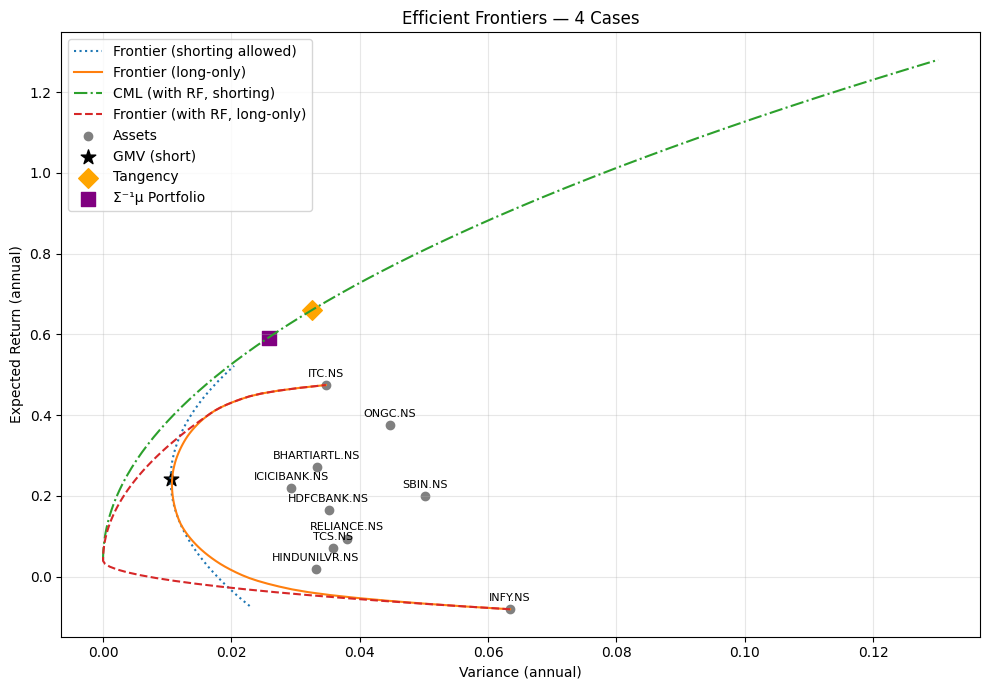

In [ ]:
# markowitz_closed_form_and_numeric.py
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------
# USER SETTINGS
# -------------------------
TICKERS = [
    "RELIANCE.NS","TCS.NS","HDFCBANK.NS","INFY.NS","ICICIBANK.NS",
    "ITC.NS","SBIN.NS","BHARTIARTL.NS","HINDUNILVR.NS","ONGC.NS"
]
TRADING_DAYS = 252
RISK_FREE_ANN = 0.04   # annual risk-free rate (for cases 3 & 4)
N_FRONTIER = 80

train_start = "2022-08-01"
train_end   = "2023-08-01"
test_start  = "2023-08-01"
test_end    = "2024-08-01"

# -------------------------
# 1) Download data (Adj Close if available, else Close)
# -------------------------
def download_prices(tickers, start, end):
    df = yf.download(tickers, start=start, end=end, progress=False)
    if "Adj Close" in df:
        return df["Adj Close"]
    elif "Close" in df:
        return df["Close"]
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' found in Yahoo Finance data.")

p_train = download_prices(TICKERS, train_start, train_end)
p_test  = download_prices(TICKERS, test_start,  test_end)


# -------------------------
# 2) Estimate parameters
# -------------------------
mu_daily = rets_train.mean().values
mu_ann   = mu_daily * TRADING_DAYS
Sigma_daily = rets_train.cov().values
Sigma_ann   = Sigma_daily * TRADING_DAYS

try:
    Sigma_inv = np.linalg.inv(Sigma_ann)
except np.linalg.LinAlgError:
    Sigma_inv = np.linalg.pinv(Sigma_ann)

ones = np.ones(N)
A = ones @ Sigma_inv @ ones
B = ones @ Sigma_inv @ mu_ann
C = mu_ann @ Sigma_inv @ mu_ann
D = A*C - B**2

# -------------------------
# 3) Portfolio formulas
# -------------------------
def w_for_target_short(r_target):
    """Closed-form weights for unconstrained (short allowed) target return."""
    coeff1 = (C - B * r_target) / D
    coeff2 = (A * r_target - B) / D
    return Sigma_inv @ (coeff1 * ones + coeff2 * mu_ann)

def w_gmv_short():
    return (Sigma_inv @ ones) / (ones @ Sigma_inv @ ones)

def w_tangency_short(rf=RISK_FREE_ANN):
    x = Sigma_inv @ (mu_ann - rf * ones)
    return x / (ones @ x)

def w_covariance(mu, Sigma):
    """Σ⁻¹μ portfolio (covariance-weighted)"""
    inv_S = np.linalg.inv(Sigma)
    w = inv_S @ mu
    return w / (np.ones(len(mu)) @ w)

def closed_form_variance(r_grid):
    return (A * r_grid**2 - 2*B*r_grid + C) / D

# -------------------------
# 4) Numeric frontier (for long-only)
# -------------------------
def get_frontier_numeric(mu_vec, Sigma_mat, allow_short=True, n_points=N_FRONTIER):
    r_min, r_max = np.min(mu_vec), np.max(mu_vec)
    r_grid = np.linspace(r_min+1e-6, r_max-1e-6, n_points)
    bounds = None if allow_short else tuple((0,1) for _ in range(len(mu_vec)))

    weights, vars_, rets = [], [], []
    for r_t in r_grid:
        cons = [
            {'type':'eq','fun': lambda w: np.sum(w) - 1},
            {'type':'eq','fun': lambda w, t=r_t: w @ mu_vec - t}
        ]
        x0 = np.ones(len(mu_vec)) / len(mu_vec)
        res = minimize(lambda w: w.T @ Sigma_mat @ w, x0,
                       method="SLSQP", bounds=bounds, constraints=cons)
        if res.success:
            weights.append(res.x)
            vars_.append(res.x @ Sigma_mat @ res.x)
            rets.append(res.x @ mu_vec)
    return {"weights":np.array(weights), "vars":np.array(vars_), "rets":np.array(rets)}

# -------------------------
# 5) Build 4 cases
# -------------------------
# Case 1: shorting allowed
r_grid_short = np.linspace(np.min(mu_ann)*0.9, np.max(mu_ann)*1.1, 300)
vars_short = closed_form_variance(r_grid_short)

# Case 2: no shorting
frontier_long = get_frontier_numeric(mu_ann, Sigma_ann, allow_short=False)

# Case 3: risky + RF, shorting allowed (CML)
w_tan = w_tangency_short()
mu_tan, sigma_tan = w_tan @ mu_ann, np.sqrt(w_tan @ Sigma_ann @ w_tan)
sigs = np.linspace(0, sigma_tan*2, 200)
r_cml = RISK_FREE_ANN + (mu_tan - RISK_FREE_ANN)/sigma_tan * sigs

# Case 4: risky + RF, no shorting
mu_aug = np.concatenate([mu_ann, [RISK_FREE_ANN]])
Sigma_aug = np.zeros((N+1, N+1)); Sigma_aug[:N,:N] = Sigma_ann
frontier_long_rf = get_frontier_numeric(mu_aug, Sigma_aug, allow_short=False)

# Test set returns and parameters
rets_train = p_train.pct_change().dropna()
rets_test  = p_test.pct_change().dropna()

mu_test = rets_test.mean().values * TRADING_DAYS
Sigma_test = rets_test.cov().values * TRADING_DAYS


# -------------------------
# 6) Key portfolios
# -------------------------
w_gmv_s = w_gmv_short()
r_gmv_s, v_gmv_s = w_gmv_s @ mu_ann, w_gmv_s @ Sigma_ann @ w_gmv_s

w_tan_s = w_tan
r_tan_s, v_tan_s = w_tan_s @ mu_ann, w_tan_s @ Sigma_ann @ w_tan_s

w_cov = w_covariance(mu_ann, Sigma_ann)
r_cov, v_cov = w_cov @ mu_ann, w_cov @ Sigma_ann @ w_cov

# -------------------------
# 7) Plotting
# -------------------------
plt.figure(figsize=(10,7))
plt.plot(vars_short, r_grid_short, ":", label="Frontier (shorting allowed)")
plt.plot(frontier_long["vars"], frontier_long["rets"], "-", label="Frontier (long-only)")
plt.plot(sigs**2, r_cml, "-.", label="CML (with RF, shorting)")
plt.plot(frontier_long_rf["vars"], frontier_long_rf["rets"], "--", label="Frontier (with RF, long-only)")

diag_vars = np.diag(Sigma_ann)
plt.scatter(diag_vars, mu_ann, c="gray", label="Assets")
for i,t in enumerate(tickers):
    plt.annotate(t, (diag_vars[i], mu_ann[i]), textcoords="offset points", xytext=(0,6), ha="center", fontsize=8)

plt.scatter(v_gmv_s, r_gmv_s, marker="*", s=120, c="k", label="GMV (short)")
plt.scatter(v_tan_s, r_tan_s, marker="D", s=100, c="orange", label="Tangency")
plt.scatter(v_cov, r_cov, marker="s", s=100, c="purple", label="Σ⁻¹μ Portfolio")

plt.xlabel("Variance (annual)")
plt.ylabel("Expected Return (annual)")
plt.title("Efficient Frontiers — 4 Cases")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
r_grid_short_oos = np.linspace(np.min(mu_test)*0.9, np.max(mu_test)*1.1, 300)
vars_short_oos = (A * r_grid_short_oos**2 - 2*B*r_grid_short_oos + C) / D  # but A,B,C,D recomputed with test μ,Σ

# Recompute A,B,C,D with test data
Sigma_inv_test = np.linalg.inv(Sigma_test)
ones_test = np.ones(len(mu_test))
A_t = ones @ Sigma_inv_test @ ones
B_t = ones @ Sigma_inv_test @ mu_test
C_t = mu_test @ Sigma_inv_test @ mu_test
D_t = A_t*C_t - B_t**2
vars_short_oos = (A_t * r_grid_short_oos**2 - 2*B_t*r_grid_short_oos + C_t) / D_t

In [ ]:
# 8) Out-of-sample performance
rets_test = p_test.pct_change().dropna()

mu_test = rets_test.mean().values * TRADING_DAYS
Sigma_test = rets_test.cov().values * TRADING_DAYS

# GMV portfolio OOS
r_gmv_oos = w_gmv_s @ mu_test
v_gmv_oos = w_gmv_s @ Sigma_test @ w_gmv_s

# Tangency portfolio OOS
r_tan_oos = w_tan_s @ mu_test
v_tan_oos = w_tan_s @ Sigma_test @ w_tan_s

# Covariance portfolio OOS (use w_cov from training)
r_cov_oos = w_cov @ mu_test
v_cov_oos = w_cov @ Sigma_test @ w_cov


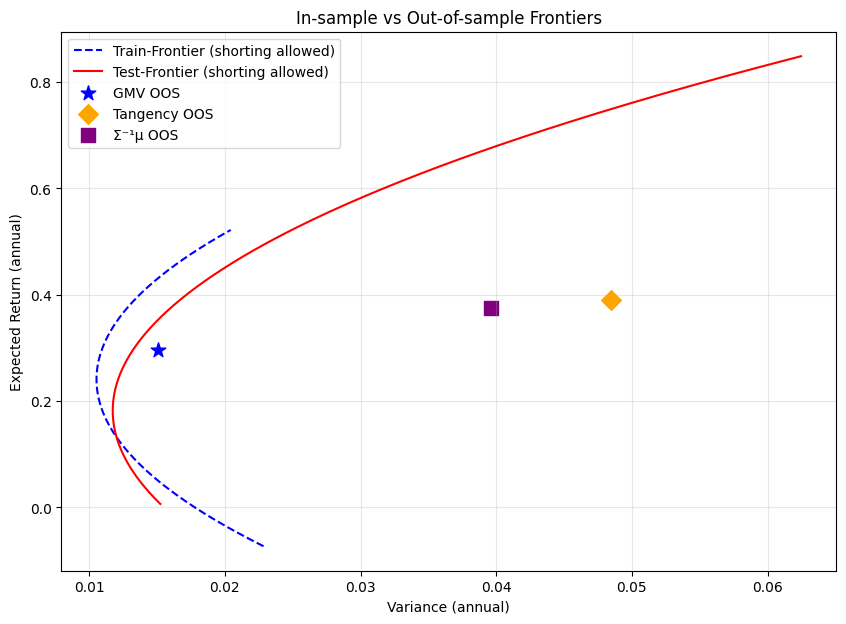

In [ ]:
plt.figure(figsize=(10,7))
# In-sample
plt.plot(vars_short, r_grid_short, "b--", label="Train-Frontier (shorting allowed)")

# Out-of-sample
plt.plot(vars_short_oos, r_grid_short_oos, "r", label="Test-Frontier (shorting allowed)")

# Highlight key portfolios OOS
plt.scatter(v_gmv_oos, r_gmv_oos, c="blue", marker="*", s=120, label="GMV OOS")
plt.scatter(v_tan_oos, r_tan_oos, c="orange", marker="D", s=100, label="Tangency OOS")
plt.scatter(v_cov_oos, r_cov_oos, c="purple", marker="s", s=100, label="Σ⁻¹μ OOS")

plt.xlabel("Variance (annual)")
plt.ylabel("Expected Return (annual)")
plt.title("In-sample vs Out-of-sample Frontiers")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



In [ ]:
import yfinance as yf
import pandas as pd

# Military & defense sector stocks
military_tickers = [
    "LMT",  # Lockheed Martin
    "NOC",  # Northrop Grumman
    "RTX",  # RTX Corporation (Raytheon)
    "GD",   # General Dynamics
    "BA",   # Boeing
    "LHX",  # L3Harris Technologies
    "HII",  # Huntington Ingalls
    "TXT",  # Textron
    "CW",   # Curtiss-Wright
    "KTOS"  # Kratos Defense
]

def data_military(tickers, start, end):
    df = yf.download(tickers, start=start, end=end, progress=False)
    if "Adj Close" in df:
        return df["Adj Close"]
    elif "Close" in df:
        return df["Close"]
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' found in Yahoo Finance data.")

# Download last 5 years of data
military_prices = data_military(military_tickers, "2019-01-01", "2024-09-01")

# Print first 10 rows
print(military_prices.head(10))




/tmp/ipython-input-843697371.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end, progress=False)


Ticker              BA          CW          GD         HII   KTOS         LHX  \
Date                                                                            
2019-01-02  314.645172   99.846848  134.083740  166.089249  13.87  117.343277   
2019-01-03  302.100555   96.386810  130.767090  162.880646  13.03  114.619911   
2019-01-04  317.822601   99.720840  134.518600  168.642365  13.70  117.149368   
2019-01-07  318.823425   99.362228  135.268906  169.047775  13.89  117.916153   
2019-01-08  330.891907  101.484787  135.277390  167.909180  14.39  117.872101   
2019-01-09  334.098541  102.095406  137.187286  165.865021  14.40  117.537148   
2019-01-10  342.630005  104.150093  138.491837  166.063324  14.44  118.885666   
2019-01-11  342.911804  104.140404  139.668442  167.779831  14.79  120.665977   
2019-01-14  340.443665  103.093666  140.282364  169.082260  14.59  121.661858   
2019-01-15  342.270477  104.663773  139.097168  170.341522  14.87  122.322937   

Ticker             LMT     

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed



PORTFOLIO OPTIMIZATION ANALYSIS

Training Period Statistics (2023-01-01 to 2024-01-01)
--------------------------------------------------
Expected Annual Returns:
Ticker
BA      0.328401
CW      0.329923
GD      0.083874
HII     0.176296
KTOS    0.798474
LHX     0.069502
LMT    -0.009670
NOC    -0.103161
RTX    -0.127909
TXT     0.165099
dtype: float64

Benchmark Rate (Government Bonds): 6.60%

Annualized Covariance Matrix:
Ticker        BA        CW        GD       HII      KTOS       LHX       LMT  \
Ticker                                                                         
BA      0.073612  0.024578  0.013529  0.019654  0.022667  0.017248  0.010038   
CW      0.024578  0.043865  0.020956  0.025813  0.035906  0.020503  0.016998   
GD      0.013529  0.020956  0.032854  0.028418  0.028741  0.025743  0.023165   
HII     0.019654  0.025813  0.028418  0.047004  0.034634  0.033812  0.027227   
KTOS    0.022667  0.035906  0.028741  0.034634  0.174936  0.036517  0.025574   
LHX     0.0

/tmp/ipython-input-922888390.py:277: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (individual_vols[i], data_dict['train_returns'][i]),
/tmp/ipython-input-922888390.py:312: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (individual_test_vols[i], data_dict['test_returns'][i]),



Analysis completed! Visualizations saved as PNG files.
Files generated:
- portfolio_optimization_analysis.png
- validation_performance_analysis.png


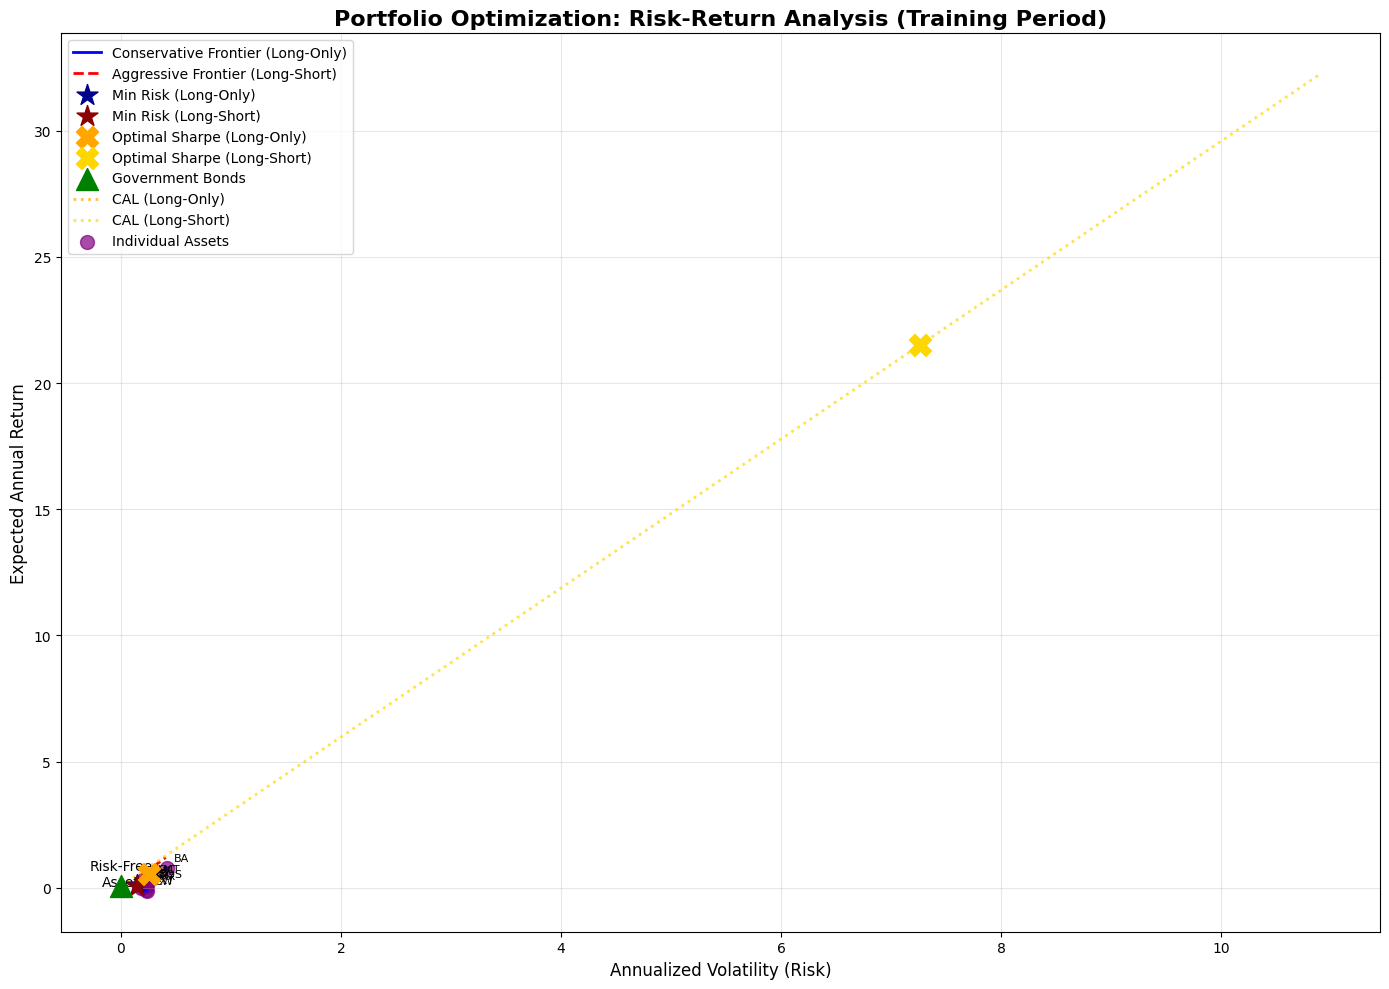

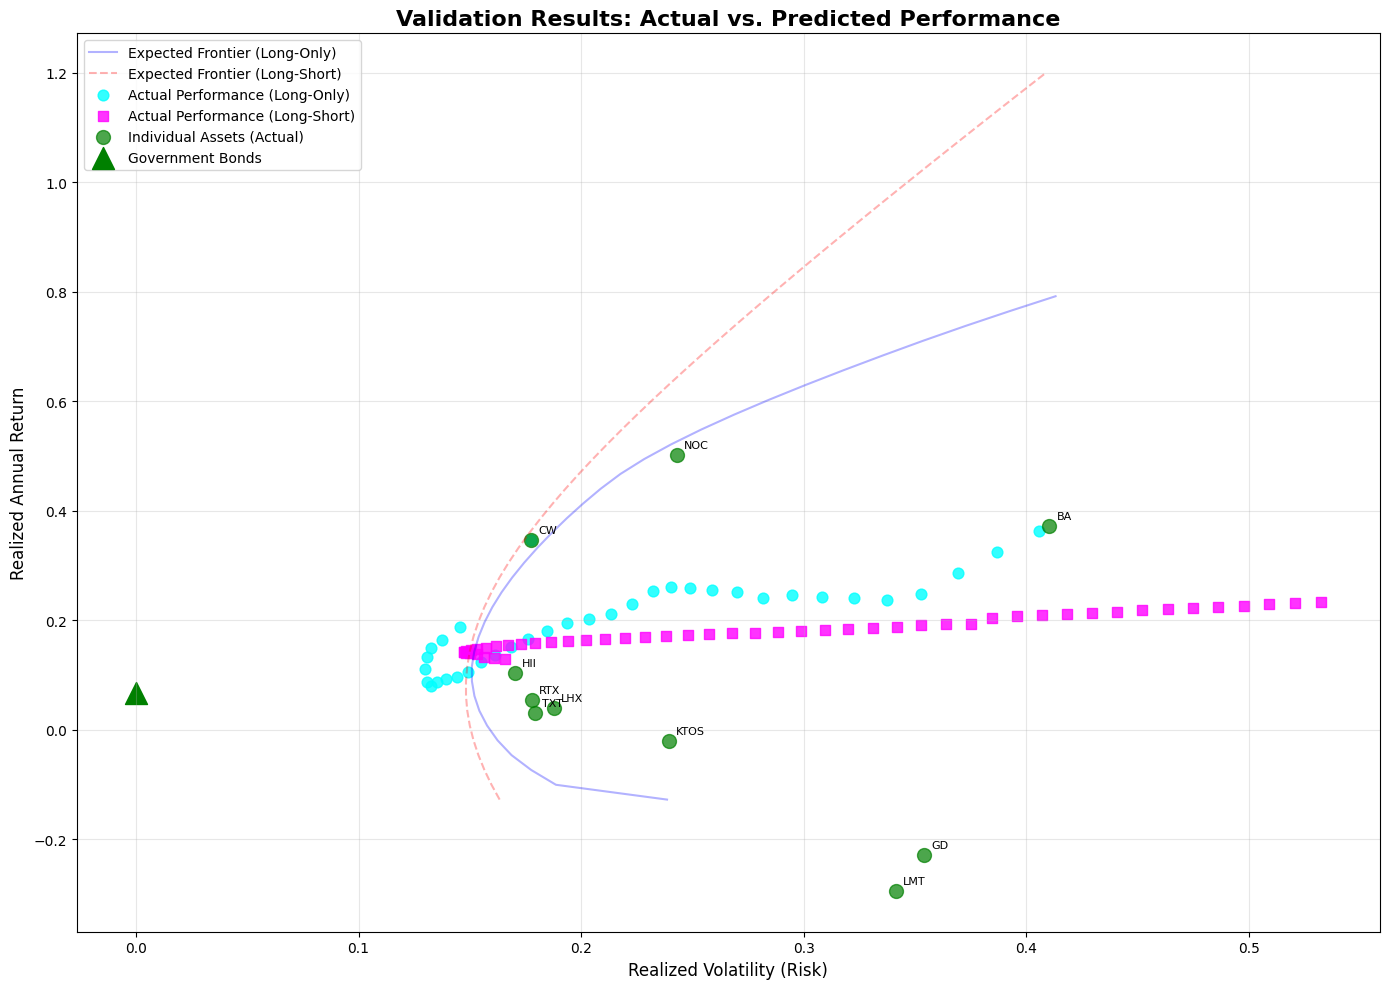

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Global Configuration
INVESTMENT_UNIVERSE = [
    "LMT",  # Lockheed Martin
    "NOC",  # Northrop Grumman
    "RTX",  # RTX Corporation (Raytheon)
    "GD",   # General Dynamics
    "BA",   # Boeing
    "LHX",  # L3Harris Technologies
    "HII",  # Huntington Ingalls
    "TXT",  # Textron
    "CW",   # Curtiss-Wright
    "KTOS"  # Kratos Defense
]

TRAINING_PERIOD_START = '2023-01-01'
TRAINING_PERIOD_END = '2024-01-01'
VALIDATION_PERIOD_START = '2024-01-01'
VALIDATION_PERIOD_END = '2025-01-01'

BENCHMARK_RATE = 0.066  # Government bond yield
DESIRED_PORTFOLIO_RETURN = 0.08

class DataManager:
    """Handles data fetching and preprocessing"""

    def __init__(self, asset_list, train_start, train_end, test_start, test_end):
        self.asset_universe = asset_list
        self.train_start = train_start
        self.train_end = train_end
        self.test_start = test_start
        self.test_end = test_end

    def fetch_price_data(self):
        """Download and clean price data"""
        train_prices = yf.download(self.asset_universe, start=self.train_start,
                                 end=self.train_end, auto_adjust=False)['Adj Close']
        test_prices = yf.download(self.asset_universe, start=self.test_start,
                                end=self.test_end, auto_adjust=False)['Adj Close']

        train_prices.dropna(inplace=True)
        test_prices.dropna(inplace=True)

        return train_prices, test_prices

    def compute_statistics(self, price_data):
        """Calculate returns and risk metrics"""
        daily_returns = price_data.pct_change().dropna()

        annualized_mean_returns = daily_returns.mean() * 252
        annualized_covariance = daily_returns.cov() * 252

        return annualized_mean_returns, annualized_covariance, daily_returns

class PortfolioOptimizer:
    """Core optimization engine"""

    def __init__(self, expected_returns, covariance_matrix, risk_free_rate):
        self.mu = expected_returns
        self.sigma = covariance_matrix
        self.rf_rate = risk_free_rate
        self.n_assets = len(expected_returns)

    def compute_portfolio_risk(self, allocation_weights, cov_matrix):
        """Calculate portfolio variance"""
        return allocation_weights.T @ cov_matrix @ allocation_weights

    def return_constraint_with_cash(self, risky_weights, expected_returns, rf_rate, target_ret):
        """Constraint for target return including cash position"""
        return np.dot(risky_weights, expected_returns) + (1 - np.sum(risky_weights)) * rf_rate - target_ret

    def optimize_mean_variance(self, target_return, allow_shorting=False):
        """Perform mean-variance optimization"""
        initial_allocation = np.array([1.0 / self.n_assets] * self.n_assets)

        constraints = [
            {'type': 'ineq', 'fun': self.return_constraint_with_cash,
             'args': (self.mu, self.rf_rate, target_return)}
        ]

        if allow_shorting:
            weight_bounds = tuple((None, None) for _ in range(self.n_assets))
        else:
            weight_bounds = tuple((0, None) for _ in range(self.n_assets))

        optimization_result = minimize(
            self.compute_portfolio_risk,
            initial_allocation,
            args=(self.sigma,),
            method='SLSQP',
            bounds=weight_bounds,
            constraints=constraints
        )

        return optimization_result

    def find_minimum_variance_portfolio(self, allow_shorting=False):
        """Find the minimum variance portfolio"""
        initial_allocation = np.array([1.0 / self.n_assets] * self.n_assets)

        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

        if allow_shorting:
            weight_bounds = tuple((None, None) for _ in range(self.n_assets))
        else:
            weight_bounds = tuple((0, 1) for _ in range(self.n_assets))

        mvp_result = minimize(
            self.compute_portfolio_risk,
            initial_allocation,
            args=(self.sigma,),
            method='SLSQP',
            bounds=weight_bounds,
            constraints=constraints
        )

        return mvp_result

    def maximize_sharpe_ratio(self, allow_shorting=False):
        """Find tangent portfolio with maximum Sharpe ratio"""
        def negative_sharpe(weights, returns, cov_matrix, rf_rate):
            portfolio_ret = np.dot(weights, returns)
            portfolio_vol = np.sqrt(weights.T @ cov_matrix @ weights)
            sharpe = (portfolio_ret - rf_rate) / portfolio_vol
            return -sharpe

        initial_allocation = np.array([1.0 / self.n_assets] * self.n_assets)
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

        if allow_shorting:
            weight_bounds = tuple((None, None) for _ in range(self.n_assets))
        else:
            weight_bounds = tuple((0, 1) for _ in range(self.n_assets))

        tangent_result = minimize(
            negative_sharpe,
            initial_allocation,
            args=(self.mu, self.sigma, self.rf_rate),
            method='SLSQP',
            bounds=weight_bounds,
            constraints=constraints
        )

        return tangent_result

class FrontierAnalyzer:
    """Generates efficient frontier analysis"""

    def __init__(self, expected_returns, covariance_matrix):
        self.mu = expected_returns
        self.sigma = covariance_matrix
        self.n_assets = len(expected_returns)

    def generate_frontier_points(self, weight_bounds, num_points=50):
        """Calculate efficient frontier coordinates"""
        min_ret = self.mu.min()
        max_ret = self.mu.max() * 1.5
        target_returns_range = np.linspace(min_ret, max_ret, num_points)

        frontier_variances = []
        frontier_returns = []
        frontier_allocations = []

        initial_guess = np.array([1.0 / self.n_assets] * self.n_assets)

        for target_ret in target_returns_range:
            constraints = [
                {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                {'type': 'eq', 'fun': lambda w: np.dot(w, self.mu) - target_ret}
            ]

            result = minimize(
                lambda w: w.T @ self.sigma @ w,
                initial_guess,
                method='SLSQP',
                bounds=weight_bounds,
                constraints=constraints
            )

            if result.success:
                frontier_variances.append(result.fun)
                frontier_returns.append(target_ret)
                frontier_allocations.append(result.x)

        return np.array(frontier_variances), np.array(frontier_returns), np.array(frontier_allocations)

class PerformanceEvaluator:
    """Handles out-of-sample performance evaluation"""

    def __init__(self, test_returns, risk_free_rate):
        self.test_returns = test_returns
        self.rf_rate = risk_free_rate

    def calculate_realized_performance(self, portfolio_weights, cash_weight, daily_returns):
        """Calculate actual portfolio performance"""
        daily_rf_rate = (1 + self.rf_rate)**(1/252) - 1
        trading_days = len(daily_returns)

        risky_daily_returns = np.dot(daily_returns, portfolio_weights)
        total_return = (1 + risky_daily_returns).prod() * (1 + daily_rf_rate)**(cash_weight * trading_days) - 1

        return total_return

    def evaluate_frontier_performance(self, frontier_weights, test_returns_annual, test_cov_annual):
        """Evaluate out-of-sample frontier performance"""
        oos_returns = [np.dot(w, test_returns_annual) for w in frontier_weights]
        oos_risks = [np.sqrt(w.T @ test_cov_annual @ w) for w in frontier_weights]

        return oos_returns, oos_risks

def display_portfolio_results(weights, asset_names, cash_weight, variance, expected_return, title):
    """Pretty print portfolio composition and metrics"""
    print(f"\n{title}")
    print("=" * len(title))
    print("Portfolio Composition:")
    for i, asset in enumerate(asset_names):
        print(f"  {asset}: {weights[i]:.4f}")
    print(f"  Government Bonds: {cash_weight:.4f}")
    print(f"\nRisk Metrics:")
    print(f"  Portfolio Variance: {variance:.6f}")
    print(f"  Portfolio Volatility: {np.sqrt(variance):.6f}")
    print(f"  Expected Annual Return: {expected_return:.4f}")

def create_visualization_suite(data_dict):
    """Generate comprehensive visualization plots"""

    # Main efficient frontier plot
    plt.figure(figsize=(14, 10))

    # Plot efficient frontiers
    plt.plot(data_dict['std_no_short'], data_dict['ret_no_short'],
             'b-', label='Conservative Frontier (Long-Only)', linewidth=2)
    plt.plot(data_dict['std_with_short'], data_dict['ret_with_short'],
             'r--', label='Aggressive Frontier (Long-Short)', linewidth=2)

    # Mark special portfolios
    plt.scatter(np.sqrt(data_dict['mvp_var_no_short']), data_dict['mvp_ret_no_short'],
                c='darkblue', marker='*', s=250, label='Min Risk (Long-Only)', zorder=5)
    plt.scatter(np.sqrt(data_dict['mvp_var_with_short']), data_dict['mvp_ret_with_short'],
                c='darkred', marker='*', s=250, label='Min Risk (Long-Short)', zorder=5)

    if not np.isnan(data_dict['tangent_vol_no_short']):
        plt.scatter(data_dict['tangent_vol_no_short'], data_dict['tangent_ret_no_short'],
                    c='orange', marker='X', s=250, label='Optimal Sharpe (Long-Only)', zorder=5)
    if not np.isnan(data_dict['tangent_vol_with_short']):
        plt.scatter(data_dict['tangent_vol_with_short'], data_dict['tangent_ret_with_short'],
                    c='gold', marker='X', s=250, label='Optimal Sharpe (Long-Short)', zorder=5)

    # Risk-free asset and capital allocation lines
    plt.scatter(0, BENCHMARK_RATE, c='green', marker='^', s=250,
                label='Government Bonds', zorder=5)
    plt.text(0, BENCHMARK_RATE + 0.005, 'Risk-Free\nAsset', fontsize=10, ha='center')

    # Capital allocation lines
    if not np.isnan(data_dict['tangent_vol_no_short']):
        cal_vols = np.linspace(0, data_dict['tangent_vol_no_short'] * 1.5, 50)
        cal_rets = BENCHMARK_RATE + (data_dict['tangent_ret_no_short'] - BENCHMARK_RATE) / data_dict['tangent_vol_no_short'] * cal_vols
        plt.plot(cal_vols, cal_rets, 'orange', linestyle=':', linewidth=2,
                 label='CAL (Long-Only)', alpha=0.7)

    if not np.isnan(data_dict['tangent_vol_with_short']):
        cal_vols = np.linspace(0, data_dict['tangent_vol_with_short'] * 1.5, 50)
        cal_rets = BENCHMARK_RATE + (data_dict['tangent_ret_with_short'] - BENCHMARK_RATE) / data_dict['tangent_vol_with_short'] * cal_vols
        plt.plot(cal_vols, cal_rets, 'gold', linestyle=':', linewidth=2,
                 label='CAL (Long-Short)', alpha=0.7)

    # Individual assets
    individual_vols = np.sqrt(data_dict['train_cov'].values.diagonal())
    plt.scatter(individual_vols, data_dict['train_returns'],
                c='purple', marker='o', s=100, alpha=0.7, label='Individual Assets')
    for i, asset in enumerate(INVESTMENT_UNIVERSE):
        plt.annotate(asset.replace('.NS', ''),
                     (individual_vols[i], data_dict['train_returns'][i]),
                     textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)

    plt.title('Portfolio Optimization: Risk-Return Analysis (Training Period)', fontsize=16, fontweight='bold')
    plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
    plt.ylabel('Expected Annual Return', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('portfolio_optimization_analysis.png', dpi=300, bbox_inches='tight')

    # Out-of-sample performance plot
    plt.figure(figsize=(14, 10))
    plt.title('Validation Results: Actual vs. Predicted Performance', fontsize=16, fontweight='bold')
    plt.xlabel('Realized Volatility (Risk)', fontsize=12)
    plt.ylabel('Realized Annual Return', fontsize=12)

    # Original frontiers (faded)
    plt.plot(data_dict['std_no_short'], data_dict['ret_no_short'],
             'b-', alpha=0.3, label='Expected Frontier (Long-Only)')
    plt.plot(data_dict['std_with_short'], data_dict['ret_with_short'],
             'r--', alpha=0.3, label='Expected Frontier (Long-Short)')

    # Out-of-sample results
    plt.scatter(data_dict['oos_vols_no_short'], data_dict['oos_rets_no_short'],
                c='cyan', marker='o', s=60, label='Actual Performance (Long-Only)', alpha=0.8)
    plt.scatter(data_dict['oos_vols_with_short'], data_dict['oos_rets_with_short'],
                c='magenta', marker='s', s=60, label='Actual Performance (Long-Short)', alpha=0.8)

    # Individual assets validation performance
    individual_test_vols = np.sqrt(data_dict['test_cov'].values.diagonal())
    plt.scatter(individual_test_vols, data_dict['test_returns'],
                c='green', marker='o', s=100, alpha=0.7, label='Individual Assets (Actual)')
    for i, asset in enumerate(INVESTMENT_UNIVERSE):
        plt.annotate(asset.replace('.NS', ''),
                     (individual_test_vols[i], data_dict['test_returns'][i]),
                     textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)

    # Risk-free reference
    plt.scatter(0, BENCHMARK_RATE, c='green', marker='^', s=250,
                label='Government Bonds')

    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('validation_performance_analysis.png', dpi=300, bbox_inches='tight')

# Main Execution Pipeline
def main():
    # Initialize data management
    data_mgr = DataManager(INVESTMENT_UNIVERSE, TRAINING_PERIOD_START, TRAINING_PERIOD_END,
                          VALIDATION_PERIOD_START, VALIDATION_PERIOD_END)

    # Fetch and process data
    train_prices, test_prices = data_mgr.fetch_price_data()
    train_returns, train_cov, train_daily_returns = data_mgr.compute_statistics(train_prices)
    test_returns, test_cov, test_daily_returns = data_mgr.compute_statistics(test_prices)

    # Display basic statistics
    print("\n" + "="*60)
    print("PORTFOLIO OPTIMIZATION ANALYSIS")
    print("="*60)
    print(f"\nTraining Period Statistics ({TRAINING_PERIOD_START} to {TRAINING_PERIOD_END})")
    print("-" * 50)
    print("Expected Annual Returns:")
    print(train_returns)
    print(f"\nBenchmark Rate (Government Bonds): {BENCHMARK_RATE:.2%}")
    print("\nAnnualized Covariance Matrix:")
    print(train_cov)

    # Initialize optimizer
    optimizer = PortfolioOptimizer(train_returns, train_cov, BENCHMARK_RATE)

    # Optimize for target return - No short selling
    result_conservative = optimizer.optimize_mean_variance(DESIRED_PORTFOLIO_RETURN, allow_shorting=False)
    conservative_weights = result_conservative.x
    conservative_cash = 1 - np.sum(conservative_weights)
    conservative_return = np.dot(conservative_weights, train_returns) + conservative_cash * BENCHMARK_RATE

    display_portfolio_results(conservative_weights, INVESTMENT_UNIVERSE, conservative_cash,
                            result_conservative.fun, conservative_return,
                            "CONSERVATIVE STRATEGY (Long-Only Positions)")

    # Optimize for target return - With short selling
    result_aggressive = optimizer.optimize_mean_variance(DESIRED_PORTFOLIO_RETURN, allow_shorting=True)
    aggressive_weights = result_aggressive.x
    aggressive_cash = 1 - np.sum(aggressive_weights)
    aggressive_return = np.dot(aggressive_weights, train_returns) + aggressive_cash * BENCHMARK_RATE

    display_portfolio_results(aggressive_weights, INVESTMENT_UNIVERSE, aggressive_cash,
                            result_aggressive.fun, aggressive_return,
                            "AGGRESSIVE STRATEGY (Long-Short Positions)")

    # Find minimum variance portfolios
    mvp_conservative = optimizer.find_minimum_variance_portfolio(allow_shorting=False)
    mvp_aggressive = optimizer.find_minimum_variance_portfolio(allow_shorting=True)

    # Find tangent portfolios
    tangent_conservative = optimizer.maximize_sharpe_ratio(allow_shorting=False)
    tangent_aggressive = optimizer.maximize_sharpe_ratio(allow_shorting=True)

    # Extract tangent portfolio metrics
    if tangent_conservative.success:
        tangent_weights_cons = tangent_conservative.x
        tangent_ret_cons = np.dot(tangent_weights_cons, train_returns)
        tangent_vol_cons = np.sqrt(tangent_weights_cons.T @ train_cov @ tangent_weights_cons)
    else:
        tangent_ret_cons = tangent_vol_cons = np.nan

    if tangent_aggressive.success:
        tangent_weights_agg = tangent_aggressive.x
        tangent_ret_agg = np.dot(tangent_weights_agg, train_returns)
        tangent_vol_agg = np.sqrt(tangent_weights_agg.T @ train_cov @ tangent_weights_agg)
    else:
        tangent_ret_agg = tangent_vol_agg = np.nan

    # Generate efficient frontiers
    frontier_analyzer = FrontierAnalyzer(train_returns, train_cov)

    # Conservative frontier
    vars_cons, rets_cons, weights_cons = frontier_analyzer.generate_frontier_points(
        tuple((0, 1) for _ in range(len(INVESTMENT_UNIVERSE))))
    vols_cons = np.sqrt(vars_cons)

    # Aggressive frontier
    vars_agg, rets_agg, weights_agg = frontier_analyzer.generate_frontier_points(
        tuple((None, None) for _ in range(len(INVESTMENT_UNIVERSE))))
    vols_agg = np.sqrt(vars_agg)

    # Out-of-sample performance evaluation
    print("\n" + "="*60)
    print("VALIDATION PERIOD PERFORMANCE")
    print("="*60)

    evaluator = PerformanceEvaluator(test_daily_returns, BENCHMARK_RATE)

    conservative_oos_return = evaluator.calculate_realized_performance(
        conservative_weights, conservative_cash, test_daily_returns)
    aggressive_oos_return = evaluator.calculate_realized_performance(
        aggressive_weights, aggressive_cash, test_daily_returns)

    print(f"\nActual Portfolio Performance ({VALIDATION_PERIOD_START} to {VALIDATION_PERIOD_END}):")
    print(f"Conservative Strategy Total Return: {conservative_oos_return:.4f} ({conservative_oos_return:.2%})")
    print(f"Aggressive Strategy Total Return: {aggressive_oos_return:.4f} ({aggressive_oos_return:.2%})")

    # Out-of-sample frontier evaluation
    oos_rets_cons, oos_vols_cons = evaluator.evaluate_frontier_performance(weights_cons, test_returns, test_cov)
    oos_rets_agg, oos_vols_agg = evaluator.evaluate_frontier_performance(weights_agg, test_returns, test_cov)

    # Prepare visualization data
    viz_data = {
        'std_no_short': vols_cons, 'ret_no_short': rets_cons,
        'std_with_short': vols_agg, 'ret_with_short': rets_agg,
        'mvp_var_no_short': mvp_conservative.fun,
        'mvp_ret_no_short': np.dot(mvp_conservative.x, train_returns),
        'mvp_var_with_short': mvp_aggressive.fun,
        'mvp_ret_with_short': np.dot(mvp_aggressive.x, train_returns),
        'tangent_vol_no_short': tangent_vol_cons, 'tangent_ret_no_short': tangent_ret_cons,
        'tangent_vol_with_short': tangent_vol_agg, 'tangent_ret_with_short': tangent_ret_agg,
        'train_returns': train_returns, 'train_cov': train_cov,
        'test_returns': test_returns, 'test_cov': test_cov,
        'oos_rets_no_short': oos_rets_cons, 'oos_vols_no_short': oos_vols_cons,
        'oos_rets_with_short': oos_rets_agg, 'oos_vols_with_short': oos_vols_agg
    }

    # Create visualizations
    create_visualization_suite(viz_data)

    print(f"\nAnalysis completed! Visualizations saved as PNG files.")
    print("Files generated:")
    print("- portfolio_optimization_analysis.png")
    print("- validation_performance_analysis.png")

if __name__ == "__main__":
    main()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed



PORTFOLIO OPTIMIZATION ANALYSIS

Training Period Statistics (2023-01-01 to 2024-01-01)
--------------------------------------------------
Expected Annual Returns:
Ticker
BPCL.NS          0.396091
HINDUNILVR.NS    0.069419
ICICIBANK.NS     0.122985
INFY.NS          0.067288
JUBLFOOD.NS      0.148288
MARUTI.NS        0.232497
POWERGRID.NS     0.485870
SBIN.NS          0.091529
TECHM.NS         0.306746
WIPRO.NS         0.209192
dtype: float64

Benchmark Rate (Government Bonds): 6.60%

Annualized Covariance Matrix:
Ticker          BPCL.NS  HINDUNILVR.NS  ICICIBANK.NS   INFY.NS  JUBLFOOD.NS  \
Ticker                                                                        
BPCL.NS        0.054131       0.007620      0.005437  0.001484     0.009216   
HINDUNILVR.NS  0.007620       0.023488      0.001927  0.008323     0.002725   
ICICIBANK.NS   0.005437       0.001927      0.024128  0.008513     0.000103   
INFY.NS        0.001484       0.008323      0.008513  0.054419     0.009055   
JUBLFOO

/tmp/ipython-input-3741015967.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (individual_vols[i], data_dict['train_returns'][i]),
/tmp/ipython-input-3741015967.py:305: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (individual_test_vols[i], data_dict['test_returns'][i]),



Analysis completed! Visualizations saved as PNG files.
Files generated:
- portfolio_optimization_analysis.png
- validation_performance_analysis.png


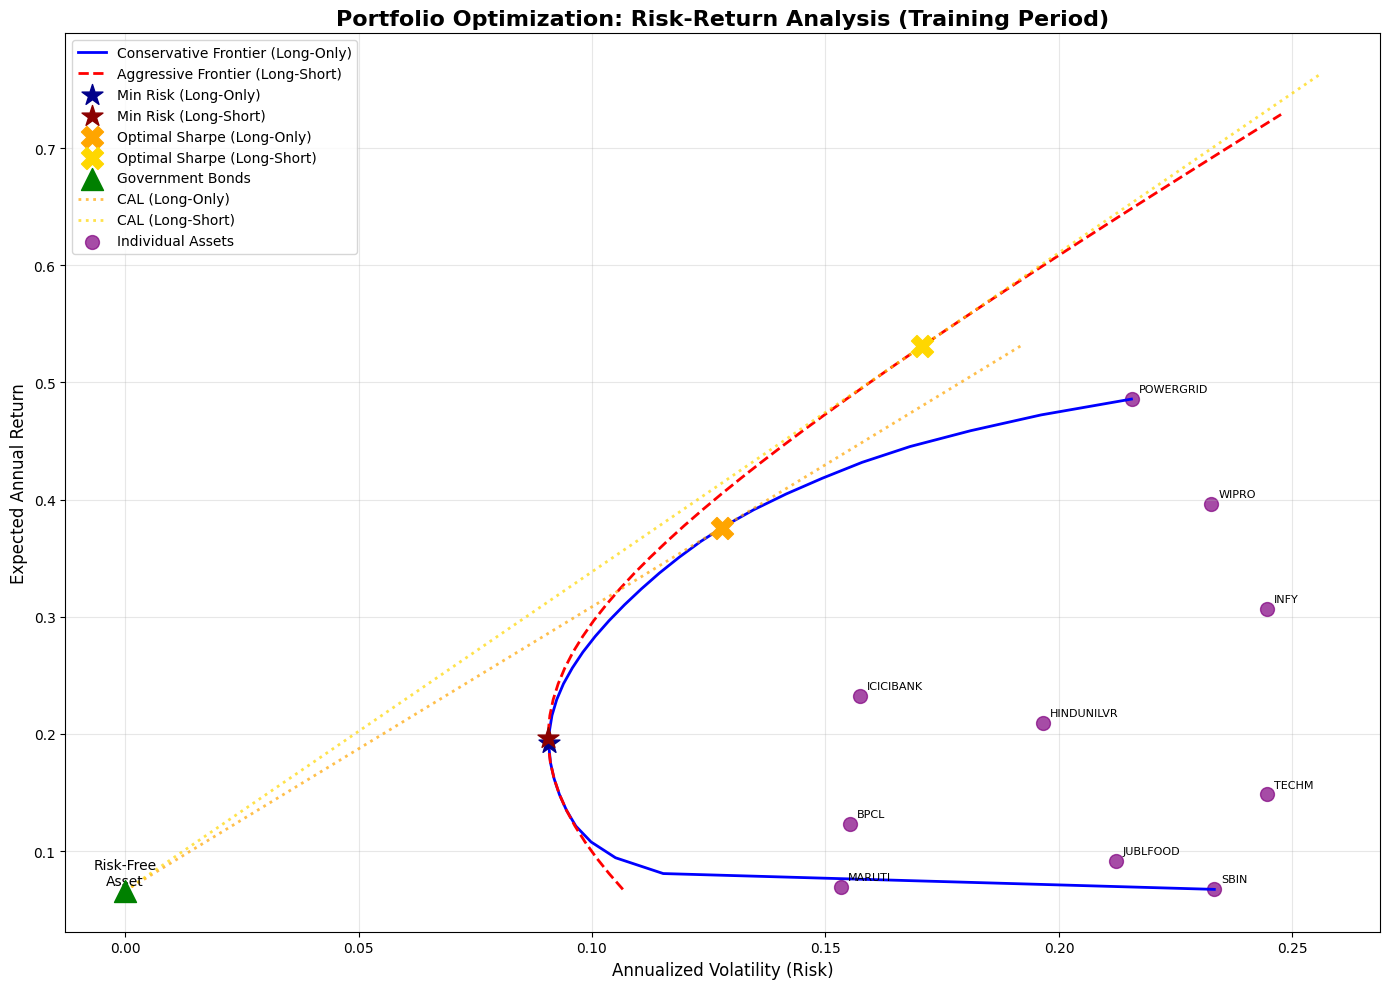

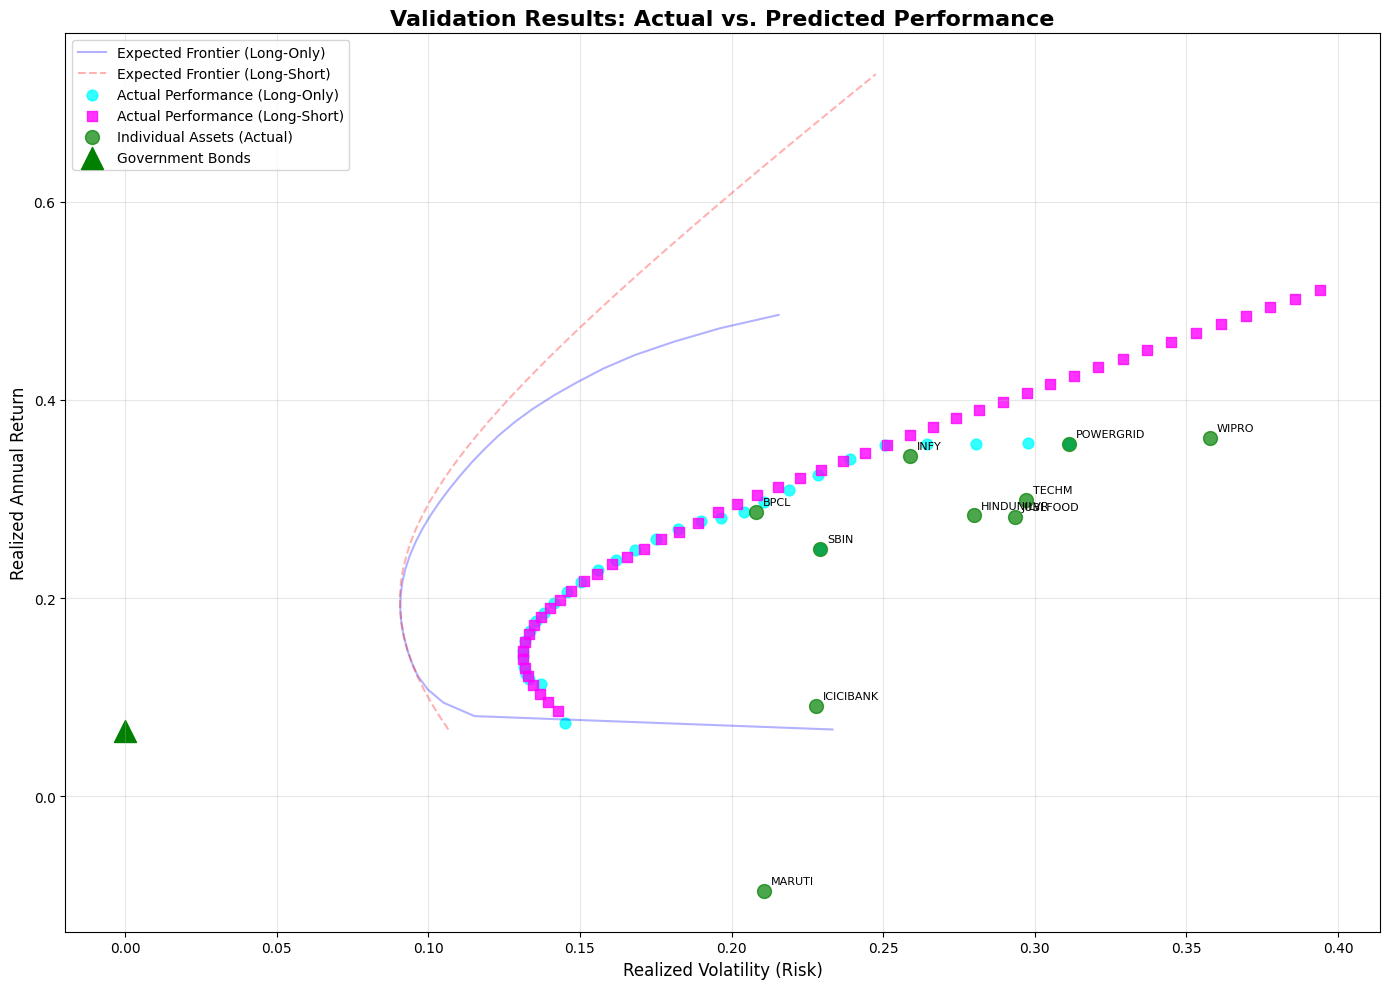

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Global Configuration
INVESTMENT_UNIVERSE = [
    'WIPRO.NS', 'MARUTI.NS', 'BPCL.NS', 'SBIN.NS',
    'TECHM.NS', 'ICICIBANK.NS', 'POWERGRID.NS', 'JUBLFOOD.NS',
    'INFY.NS', 'HINDUNILVR.NS'
]

TRAINING_PERIOD_START = '2023-01-01'
TRAINING_PERIOD_END = '2024-01-01'
VALIDATION_PERIOD_START = '2024-01-01'
VALIDATION_PERIOD_END = '2025-01-01'

BENCHMARK_RATE = 0.066  # Government bond yield
DESIRED_PORTFOLIO_RETURN = 0.15

class DataManager:
    """Handles data fetching and preprocessing"""

    def __init__(self, asset_list, train_start, train_end, test_start, test_end):
        self.asset_universe = asset_list
        self.train_start = train_start
        self.train_end = train_end
        self.test_start = test_start
        self.test_end = test_end

    def fetch_price_data(self):
        """Download and clean price data"""
        train_prices = yf.download(self.asset_universe, start=self.train_start,
                                 end=self.train_end, auto_adjust=False)['Adj Close']
        test_prices = yf.download(self.asset_universe, start=self.test_start,
                                end=self.test_end, auto_adjust=False)['Adj Close']

        train_prices.dropna(inplace=True)
        test_prices.dropna(inplace=True)

        return train_prices, test_prices

    def compute_statistics(self, price_data):
        """Calculate returns and risk metrics"""
        daily_returns = price_data.pct_change().dropna()

        annualized_mean_returns = daily_returns.mean() * 252
        annualized_covariance = daily_returns.cov() * 252

        return annualized_mean_returns, annualized_covariance, daily_returns

class PortfolioOptimizer:
    """Core optimization engine"""

    def __init__(self, expected_returns, covariance_matrix, risk_free_rate):
        self.mu = expected_returns
        self.sigma = covariance_matrix
        self.rf_rate = risk_free_rate
        self.n_assets = len(expected_returns)

    def compute_portfolio_risk(self, allocation_weights, cov_matrix):
        """Calculate portfolio variance"""
        return allocation_weights.T @ cov_matrix @ allocation_weights

    def return_constraint_with_cash(self, risky_weights, expected_returns, rf_rate, target_ret):
        """Constraint for target return including cash position"""
        return np.dot(risky_weights, expected_returns) + (1 - np.sum(risky_weights)) * rf_rate - target_ret

    def optimize_mean_variance(self, target_return, allow_shorting=False):
        """Perform mean-variance optimization"""
        initial_allocation = np.array([1.0 / self.n_assets] * self.n_assets)

        constraints = [
            {'type': 'ineq', 'fun': self.return_constraint_with_cash,
             'args': (self.mu, self.rf_rate, target_return)}
        ]

        if allow_shorting:
            weight_bounds = tuple((None, None) for _ in range(self.n_assets))
        else:
            weight_bounds = tuple((0, None) for _ in range(self.n_assets))

        optimization_result = minimize(
            self.compute_portfolio_risk,
            initial_allocation,
            args=(self.sigma,),
            method='SLSQP',
            bounds=weight_bounds,
            constraints=constraints
        )

        return optimization_result

    def find_minimum_variance_portfolio(self, allow_shorting=False):
        """Find the minimum variance portfolio"""
        initial_allocation = np.array([1.0 / self.n_assets] * self.n_assets)

        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

        if allow_shorting:
            weight_bounds = tuple((None, None) for _ in range(self.n_assets))
        else:
            weight_bounds = tuple((0, 1) for _ in range(self.n_assets))

        mvp_result = minimize(
            self.compute_portfolio_risk,
            initial_allocation,
            args=(self.sigma,),
            method='SLSQP',
            bounds=weight_bounds,
            constraints=constraints
        )

        return mvp_result

    def maximize_sharpe_ratio(self, allow_shorting=False):
        """Find tangent portfolio with maximum Sharpe ratio"""
        def negative_sharpe(weights, returns, cov_matrix, rf_rate):
            portfolio_ret = np.dot(weights, returns)
            portfolio_vol = np.sqrt(weights.T @ cov_matrix @ weights)
            sharpe = (portfolio_ret - rf_rate) / portfolio_vol
            return -sharpe

        initial_allocation = np.array([1.0 / self.n_assets] * self.n_assets)
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

        if allow_shorting:
            weight_bounds = tuple((None, None) for _ in range(self.n_assets))
        else:
            weight_bounds = tuple((0, 1) for _ in range(self.n_assets))

        tangent_result = minimize(
            negative_sharpe,
            initial_allocation,
            args=(self.mu, self.sigma, self.rf_rate),
            method='SLSQP',
            bounds=weight_bounds,
            constraints=constraints
        )

        return tangent_result

class FrontierAnalyzer:
    """Generates efficient frontier analysis"""

    def __init__(self, expected_returns, covariance_matrix):
        self.mu = expected_returns
        self.sigma = covariance_matrix
        self.n_assets = len(expected_returns)

    def generate_frontier_points(self, weight_bounds, num_points=50):
        """Calculate efficient frontier coordinates"""
        min_ret = self.mu.min()
        max_ret = self.mu.max() * 1.5
        target_returns_range = np.linspace(min_ret, max_ret, num_points)

        frontier_variances = []
        frontier_returns = []
        frontier_allocations = []

        initial_guess = np.array([1.0 / self.n_assets] * self.n_assets)

        for target_ret in target_returns_range:
            constraints = [
                {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                {'type': 'eq', 'fun': lambda w: np.dot(w, self.mu) - target_ret}
            ]

            result = minimize(
                lambda w: w.T @ self.sigma @ w,
                initial_guess,
                method='SLSQP',
                bounds=weight_bounds,
                constraints=constraints
            )

            if result.success:
                frontier_variances.append(result.fun)
                frontier_returns.append(target_ret)
                frontier_allocations.append(result.x)

        return np.array(frontier_variances), np.array(frontier_returns), np.array(frontier_allocations)

class PerformanceEvaluator:
    """Handles out-of-sample performance evaluation"""

    def __init__(self, test_returns, risk_free_rate):
        self.test_returns = test_returns
        self.rf_rate = risk_free_rate

    def calculate_realized_performance(self, portfolio_weights, cash_weight, daily_returns):
        """Calculate actual portfolio performance"""
        daily_rf_rate = (1 + self.rf_rate)**(1/252) - 1
        trading_days = len(daily_returns)

        risky_daily_returns = np.dot(daily_returns, portfolio_weights)
        total_return = (1 + risky_daily_returns).prod() * (1 + daily_rf_rate)**(cash_weight * trading_days) - 1

        return total_return

    def evaluate_frontier_performance(self, frontier_weights, test_returns_annual, test_cov_annual):
        """Evaluate out-of-sample frontier performance"""
        oos_returns = [np.dot(w, test_returns_annual) for w in frontier_weights]
        oos_risks = [np.sqrt(w.T @ test_cov_annual @ w) for w in frontier_weights]

        return oos_returns, oos_risks

def display_portfolio_results(weights, asset_names, cash_weight, variance, expected_return, title):
    """Pretty print portfolio composition and metrics"""
    print(f"\n{title}")
    print("=" * len(title))
    print("Portfolio Composition:")
    for i, asset in enumerate(asset_names):
        print(f"  {asset}: {weights[i]:.4f}")
    print(f"  Government Bonds: {cash_weight:.4f}")
    print(f"\nRisk Metrics:")
    print(f"  Portfolio Variance: {variance:.6f}")
    print(f"  Portfolio Volatility: {np.sqrt(variance):.6f}")
    print(f"  Expected Annual Return: {expected_return:.4f}")

def create_visualization_suite(data_dict):
    """Generate comprehensive visualization plots"""

    # Main efficient frontier plot
    plt.figure(figsize=(14, 10))

    # Plot efficient frontiers
    plt.plot(data_dict['std_no_short'], data_dict['ret_no_short'],
             'b-', label='Conservative Frontier (Long-Only)', linewidth=2)
    plt.plot(data_dict['std_with_short'], data_dict['ret_with_short'],
             'r--', label='Aggressive Frontier (Long-Short)', linewidth=2)

    # Mark special portfolios
    plt.scatter(np.sqrt(data_dict['mvp_var_no_short']), data_dict['mvp_ret_no_short'],
                c='darkblue', marker='*', s=250, label='Min Risk (Long-Only)', zorder=5)
    plt.scatter(np.sqrt(data_dict['mvp_var_with_short']), data_dict['mvp_ret_with_short'],
                c='darkred', marker='*', s=250, label='Min Risk (Long-Short)', zorder=5)

    if not np.isnan(data_dict['tangent_vol_no_short']):
        plt.scatter(data_dict['tangent_vol_no_short'], data_dict['tangent_ret_no_short'],
                    c='orange', marker='X', s=250, label='Optimal Sharpe (Long-Only)', zorder=5)
    if not np.isnan(data_dict['tangent_vol_with_short']):
        plt.scatter(data_dict['tangent_vol_with_short'], data_dict['tangent_ret_with_short'],
                    c='gold', marker='X', s=250, label='Optimal Sharpe (Long-Short)', zorder=5)

    # Risk-free asset and capital allocation lines
    plt.scatter(0, BENCHMARK_RATE, c='green', marker='^', s=250,
                label='Government Bonds', zorder=5)
    plt.text(0, BENCHMARK_RATE + 0.005, 'Risk-Free\nAsset', fontsize=10, ha='center')

    # Capital allocation lines
    if not np.isnan(data_dict['tangent_vol_no_short']):
        cal_vols = np.linspace(0, data_dict['tangent_vol_no_short'] * 1.5, 50)
        cal_rets = BENCHMARK_RATE + (data_dict['tangent_ret_no_short'] - BENCHMARK_RATE) / data_dict['tangent_vol_no_short'] * cal_vols
        plt.plot(cal_vols, cal_rets, 'orange', linestyle=':', linewidth=2,
                 label='CAL (Long-Only)', alpha=0.7)

    if not np.isnan(data_dict['tangent_vol_with_short']):
        cal_vols = np.linspace(0, data_dict['tangent_vol_with_short'] * 1.5, 50)
        cal_rets = BENCHMARK_RATE + (data_dict['tangent_ret_with_short'] - BENCHMARK_RATE) / data_dict['tangent_vol_with_short'] * cal_vols
        plt.plot(cal_vols, cal_rets, 'gold', linestyle=':', linewidth=2,
                 label='CAL (Long-Short)', alpha=0.7)

    # Individual assets
    individual_vols = np.sqrt(data_dict['train_cov'].values.diagonal())
    plt.scatter(individual_vols, data_dict['train_returns'],
                c='purple', marker='o', s=100, alpha=0.7, label='Individual Assets')
    for i, asset in enumerate(INVESTMENT_UNIVERSE):
        plt.annotate(asset.replace('.NS', ''),
                     (individual_vols[i], data_dict['train_returns'][i]),
                     textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)

    plt.title('Portfolio Optimization: Risk-Return Analysis (Training Period)', fontsize=16, fontweight='bold')
    plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
    plt.ylabel('Expected Annual Return', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('portfolio_optimization_analysis.png', dpi=300, bbox_inches='tight')

    # Out-of-sample performance plot
    plt.figure(figsize=(14, 10))
    plt.title('Validation Results: Actual vs. Predicted Performance', fontsize=16, fontweight='bold')
    plt.xlabel('Realized Volatility (Risk)', fontsize=12)
    plt.ylabel('Realized Annual Return', fontsize=12)

    # Original frontiers (faded)
    plt.plot(data_dict['std_no_short'], data_dict['ret_no_short'],
             'b-', alpha=0.3, label='Expected Frontier (Long-Only)')
    plt.plot(data_dict['std_with_short'], data_dict['ret_with_short'],
             'r--', alpha=0.3, label='Expected Frontier (Long-Short)')

    # Out-of-sample results
    plt.scatter(data_dict['oos_vols_no_short'], data_dict['oos_rets_no_short'],
                c='cyan', marker='o', s=60, label='Actual Performance (Long-Only)', alpha=0.8)
    plt.scatter(data_dict['oos_vols_with_short'], data_dict['oos_rets_with_short'],
                c='magenta', marker='s', s=60, label='Actual Performance (Long-Short)', alpha=0.8)

    # Individual assets validation performance
    individual_test_vols = np.sqrt(data_dict['test_cov'].values.diagonal())
    plt.scatter(individual_test_vols, data_dict['test_returns'],
                c='green', marker='o', s=100, alpha=0.7, label='Individual Assets (Actual)')
    for i, asset in enumerate(INVESTMENT_UNIVERSE):
        plt.annotate(asset.replace('.NS', ''),
                     (individual_test_vols[i], data_dict['test_returns'][i]),
                     textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)

    # Risk-free reference
    plt.scatter(0, BENCHMARK_RATE, c='green', marker='^', s=250,
                label='Government Bonds')

    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('validation_performance_analysis.png', dpi=300, bbox_inches='tight')

# Main Execution Pipeline
def main():
    # Initialize data management
    data_mgr = DataManager(INVESTMENT_UNIVERSE, TRAINING_PERIOD_START, TRAINING_PERIOD_END,
                          VALIDATION_PERIOD_START, VALIDATION_PERIOD_END)

    # Fetch and process data
    train_prices, test_prices = data_mgr.fetch_price_data()
    train_returns, train_cov, train_daily_returns = data_mgr.compute_statistics(train_prices)
    test_returns, test_cov, test_daily_returns = data_mgr.compute_statistics(test_prices)

    # Display basic statistics
    print("\n" + "="*60)
    print("PORTFOLIO OPTIMIZATION ANALYSIS")
    print("="*60)
    print(f"\nTraining Period Statistics ({TRAINING_PERIOD_START} to {TRAINING_PERIOD_END})")
    print("-" * 50)
    print("Expected Annual Returns:")
    print(train_returns)
    print(f"\nBenchmark Rate (Government Bonds): {BENCHMARK_RATE:.2%}")
    print("\nAnnualized Covariance Matrix:")
    print(train_cov)

    # Initialize optimizer
    optimizer = PortfolioOptimizer(train_returns, train_cov, BENCHMARK_RATE)

    # Optimize for target return - No short selling
    result_conservative = optimizer.optimize_mean_variance(DESIRED_PORTFOLIO_RETURN, allow_shorting=False)
    conservative_weights = result_conservative.x
    conservative_cash = 1 - np.sum(conservative_weights)
    conservative_return = np.dot(conservative_weights, train_returns) + conservative_cash * BENCHMARK_RATE

    display_portfolio_results(conservative_weights, INVESTMENT_UNIVERSE, conservative_cash,
                            result_conservative.fun, conservative_return,
                            "CONSERVATIVE STRATEGY (Long-Only Positions)")

    # Optimize for target return - With short selling
    result_aggressive = optimizer.optimize_mean_variance(DESIRED_PORTFOLIO_RETURN, allow_shorting=True)
    aggressive_weights = result_aggressive.x
    aggressive_cash = 1 - np.sum(aggressive_weights)
    aggressive_return = np.dot(aggressive_weights, train_returns) + aggressive_cash * BENCHMARK_RATE

    display_portfolio_results(aggressive_weights, INVESTMENT_UNIVERSE, aggressive_cash,
                            result_aggressive.fun, aggressive_return,
                            "AGGRESSIVE STRATEGY (Long-Short Positions)")

    # Find minimum variance portfolios
    mvp_conservative = optimizer.find_minimum_variance_portfolio(allow_shorting=False)
    mvp_aggressive = optimizer.find_minimum_variance_portfolio(allow_shorting=True)

    # Find tangent portfolios
    tangent_conservative = optimizer.maximize_sharpe_ratio(allow_shorting=False)
    tangent_aggressive = optimizer.maximize_sharpe_ratio(allow_shorting=True)

    # Extract tangent portfolio metrics
    if tangent_conservative.success:
        tangent_weights_cons = tangent_conservative.x
        tangent_ret_cons = np.dot(tangent_weights_cons, train_returns)
        tangent_vol_cons = np.sqrt(tangent_weights_cons.T @ train_cov @ tangent_weights_cons)
    else:
        tangent_ret_cons = tangent_vol_cons = np.nan

    if tangent_aggressive.success:
        tangent_weights_agg = tangent_aggressive.x
        tangent_ret_agg = np.dot(tangent_weights_agg, train_returns)
        tangent_vol_agg = np.sqrt(tangent_weights_agg.T @ train_cov @ tangent_weights_agg)
    else:
        tangent_ret_agg = tangent_vol_agg = np.nan

    # Generate efficient frontiers
    frontier_analyzer = FrontierAnalyzer(train_returns, train_cov)

    # Conservative frontier
    vars_cons, rets_cons, weights_cons = frontier_analyzer.generate_frontier_points(
        tuple((0, 1) for _ in range(len(INVESTMENT_UNIVERSE))))
    vols_cons = np.sqrt(vars_cons)

    # Aggressive frontier
    vars_agg, rets_agg, weights_agg = frontier_analyzer.generate_frontier_points(
        tuple((None, None) for _ in range(len(INVESTMENT_UNIVERSE))))
    vols_agg = np.sqrt(vars_agg)

    # Out-of-sample performance evaluation
    print("\n" + "="*60)
    print("VALIDATION PERIOD PERFORMANCE")
    print("="*60)

    evaluator = PerformanceEvaluator(test_daily_returns, BENCHMARK_RATE)

    conservative_oos_return = evaluator.calculate_realized_performance(
        conservative_weights, conservative_cash, test_daily_returns)
    aggressive_oos_return = evaluator.calculate_realized_performance(
        aggressive_weights, aggressive_cash, test_daily_returns)

    print(f"\nActual Portfolio Performance ({VALIDATION_PERIOD_START} to {VALIDATION_PERIOD_END}):")
    print(f"Conservative Strategy Total Return: {conservative_oos_return:.4f} ({conservative_oos_return:.2%})")
    print(f"Aggressive Strategy Total Return: {aggressive_oos_return:.4f} ({aggressive_oos_return:.2%})")

    # Out-of-sample frontier evaluation
    oos_rets_cons, oos_vols_cons = evaluator.evaluate_frontier_performance(weights_cons, test_returns, test_cov)
    oos_rets_agg, oos_vols_agg = evaluator.evaluate_frontier_performance(weights_agg, test_returns, test_cov)

    # Prepare visualization data
    viz_data = {
        'std_no_short': vols_cons, 'ret_no_short': rets_cons,
        'std_with_short': vols_agg, 'ret_with_short': rets_agg,
        'mvp_var_no_short': mvp_conservative.fun,
        'mvp_ret_no_short': np.dot(mvp_conservative.x, train_returns),
        'mvp_var_with_short': mvp_aggressive.fun,
        'mvp_ret_with_short': np.dot(mvp_aggressive.x, train_returns),
        'tangent_vol_no_short': tangent_vol_cons, 'tangent_ret_no_short': tangent_ret_cons,
        'tangent_vol_with_short': tangent_vol_agg, 'tangent_ret_with_short': tangent_ret_agg,
        'train_returns': train_returns, 'train_cov': train_cov,
        'test_returns': test_returns, 'test_cov': test_cov,
        'oos_rets_no_short': oos_rets_cons, 'oos_vols_no_short': oos_vols_cons,
        'oos_rets_with_short': oos_rets_agg, 'oos_vols_with_short': oos_vols_agg
    }

    # Create visualizations
    create_visualization_suite(viz_data)

    print(f"\nAnalysis completed! Visualizations saved as PNG files.")
    print("Files generated:")
    print("- portfolio_optimization_analysis.png")
    print("- validation_performance_analysis.png")

if __name__ == "__main__":
    main()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed



PORTFOLIO OPTIMIZATION ANALYSIS - MILITARY/DEFENSE SECTOR

Training Period Statistics (2023-01-01 to 2024-01-01)
--------------------------------------------------
Expected Annual Returns:
Ticker
BDL.NS           0.701430
BEL.NS           0.684163
BHARATFORG.NS    0.379927
COCHINSHIP.NS    1.128524
GRSE.NS          0.743117
HAL.NS           0.873029
LT.NS            0.568599
MAZDOCK.NS       1.233636
SOLARINDS.NS     0.479496
TATAPOWER.NS     0.508054
dtype: float64

Benchmark Rate (Government Bonds): 6.60%

Annualized Covariance Matrix:
Ticker           BDL.NS    BEL.NS  BHARATFORG.NS  COCHINSHIP.NS   GRSE.NS  \
Ticker                                                                      
BDL.NS         0.155817  0.051672       0.026331       0.085809  0.074172   
BEL.NS         0.051672  0.074511       0.022054       0.046778  0.037686   
BHARATFORG.NS  0.026331  0.022054       0.050231       0.024087  0.022651   
COCHINSHIP.NS  0.085809  0.046778       0.024087       0.275712  0.193

/tmp/ipython-input-3945503723.py:269: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (individual_vols[i], data_dict['train_returns'][i]),
/tmp/ipython-input-3945503723.py:304: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (individual_test_vols[i], data_dict['test_returns'][i]),



Analysis completed! Visualizations saved as PNG files.
Files generated:
- portfolio_optimization_analysis.png
- validation_performance_analysis.png


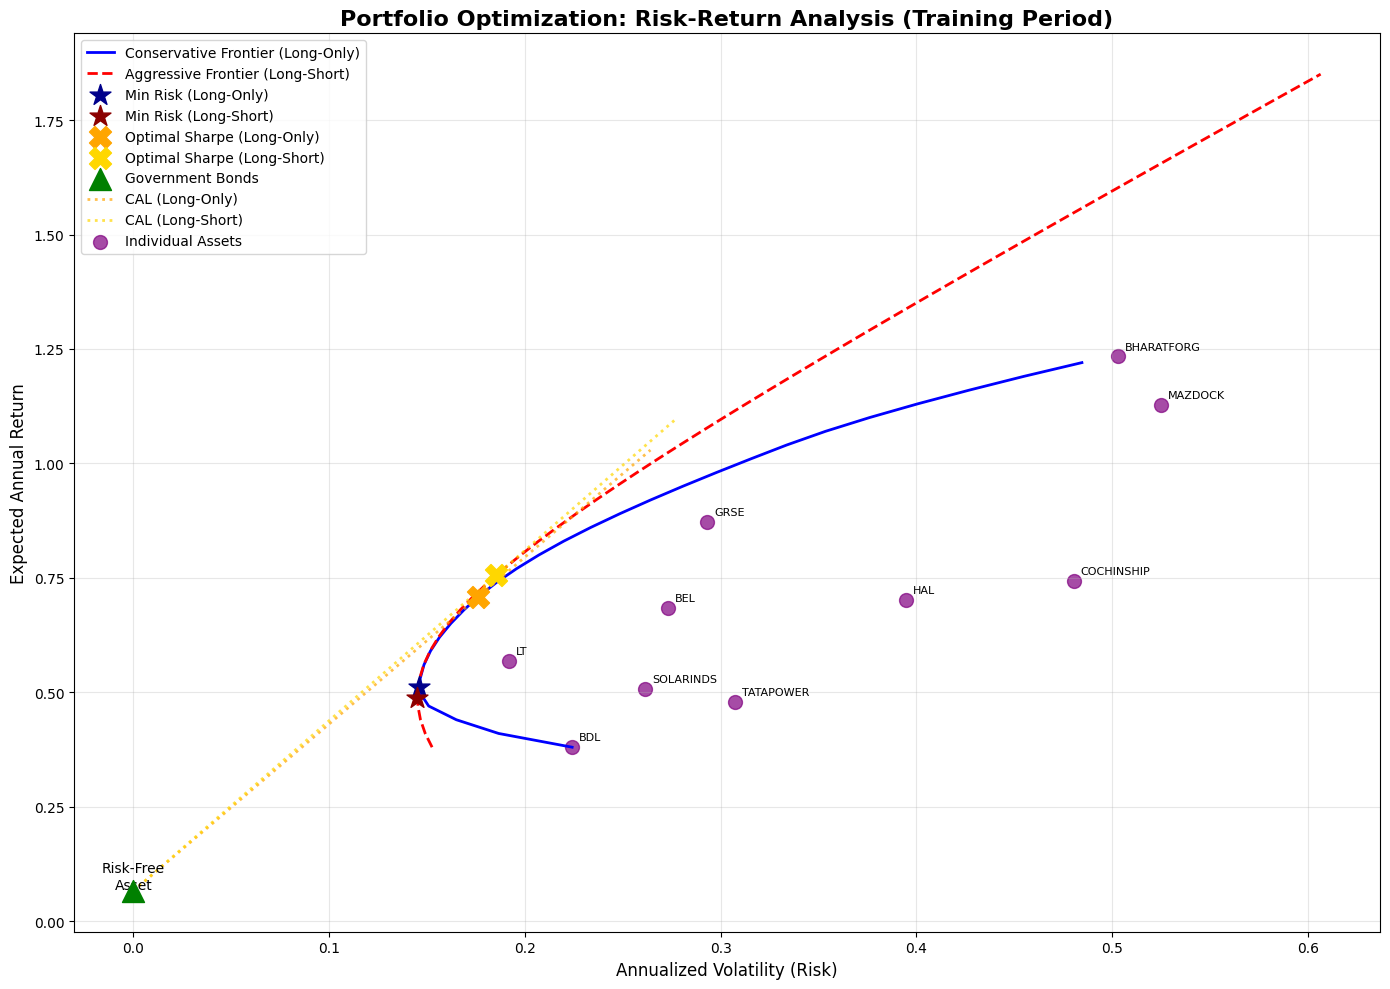

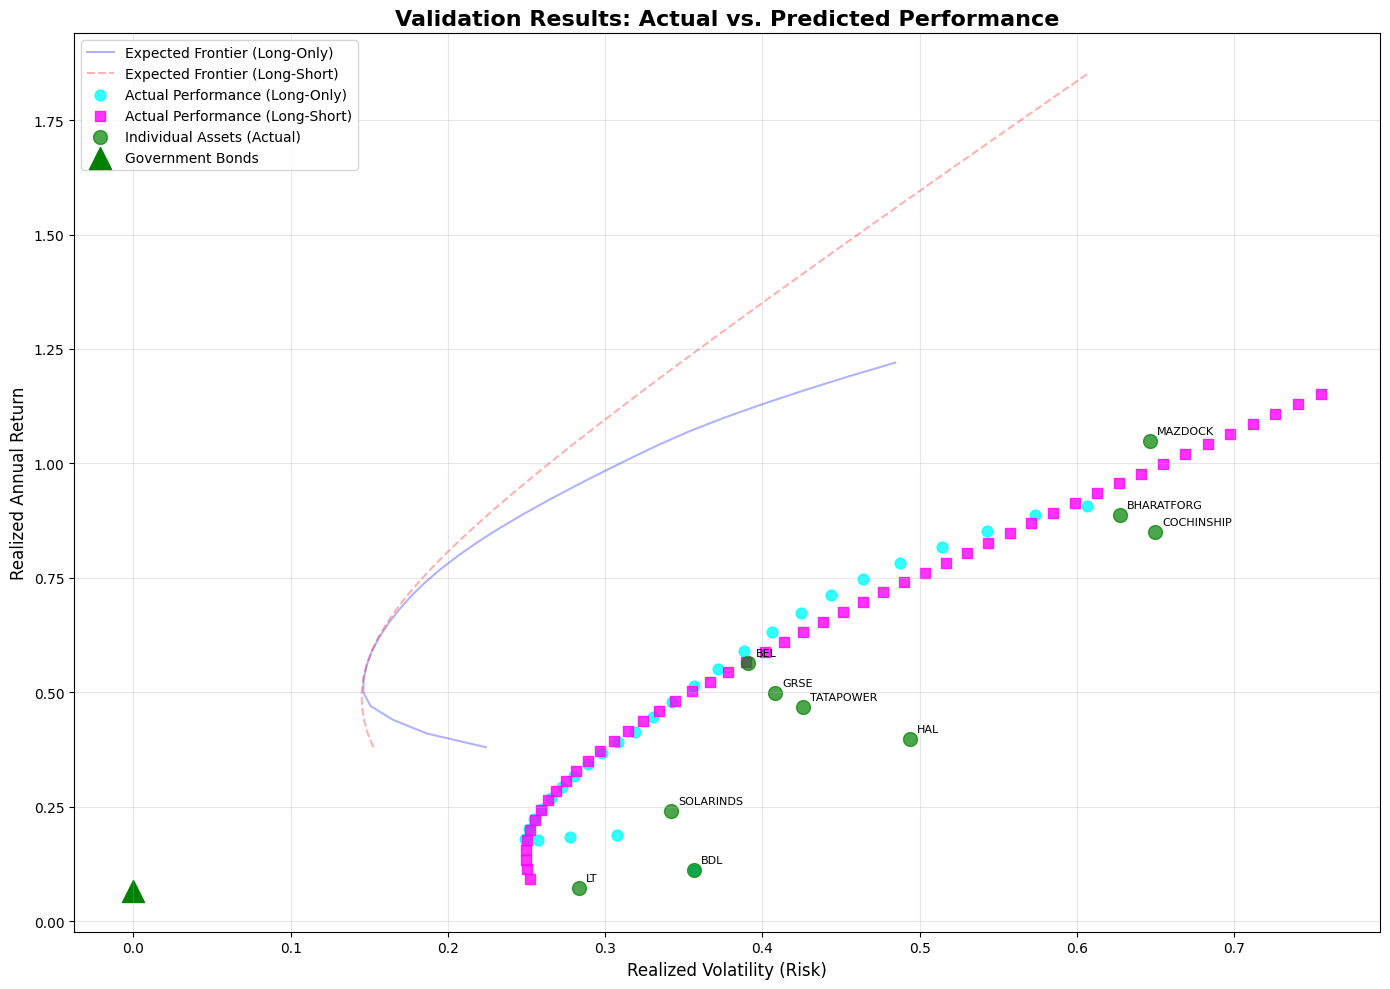

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Global Configuration
INVESTMENT_UNIVERSE = [
    'HAL.NS', 'BEL.NS', 'BDL.NS', 'MAZDOCK.NS', 'COCHINSHIP.NS',
    'GRSE.NS', 'LT.NS', 'BHARATFORG.NS', 'TATAPOWER.NS', 'SOLARINDS.NS'
]

TRAINING_PERIOD_START = '2023-01-01'
TRAINING_PERIOD_END = '2024-01-01'
VALIDATION_PERIOD_START = '2024-01-01'
VALIDATION_PERIOD_END = '2025-01-01'

BENCHMARK_RATE = 0.066  # Government bond yield
DESIRED_PORTFOLIO_RETURN = 0.15

class DataManager:
    """Handles data fetching and preprocessing"""

    def __init__(self, asset_list, train_start, train_end, test_start, test_end):
        self.asset_universe = asset_list
        self.train_start = train_start
        self.train_end = train_end
        self.test_start = test_start
        self.test_end = test_end

    def fetch_price_data(self):
        """Download and clean price data"""
        train_prices = yf.download(self.asset_universe, start=self.train_start,
                                 end=self.train_end, auto_adjust=False)['Adj Close']
        test_prices = yf.download(self.asset_universe, start=self.test_start,
                                end=self.test_end, auto_adjust=False)['Adj Close']

        train_prices.dropna(inplace=True)
        test_prices.dropna(inplace=True)

        return train_prices, test_prices

    def compute_statistics(self, price_data):
        """Calculate returns and risk metrics"""
        daily_returns = price_data.pct_change().dropna()

        annualized_mean_returns = daily_returns.mean() * 252
        annualized_covariance = daily_returns.cov() * 252

        return annualized_mean_returns, annualized_covariance, daily_returns

class PortfolioOptimizer:
    """Core optimization engine"""

    def __init__(self, expected_returns, covariance_matrix, risk_free_rate):
        self.mu = expected_returns
        self.sigma = covariance_matrix
        self.rf_rate = risk_free_rate
        self.n_assets = len(expected_returns)

    def compute_portfolio_risk(self, allocation_weights, cov_matrix):
        """Calculate portfolio variance"""
        return allocation_weights.T @ cov_matrix @ allocation_weights

    def return_constraint_with_cash(self, risky_weights, expected_returns, rf_rate, target_ret):
        """Constraint for target return including cash position"""
        return np.dot(risky_weights, expected_returns) + (1 - np.sum(risky_weights)) * rf_rate - target_ret

    def optimize_mean_variance(self, target_return, allow_shorting=False):
        """Perform mean-variance optimization"""
        initial_allocation = np.array([1.0 / self.n_assets] * self.n_assets)

        constraints = [
            {'type': 'ineq', 'fun': self.return_constraint_with_cash,
             'args': (self.mu, self.rf_rate, target_return)}
        ]

        if allow_shorting:
            weight_bounds = tuple((None, None) for _ in range(self.n_assets))
        else:
            weight_bounds = tuple((0, None) for _ in range(self.n_assets))

        optimization_result = minimize(
            self.compute_portfolio_risk,
            initial_allocation,
            args=(self.sigma,),
            method='SLSQP',
            bounds=weight_bounds,
            constraints=constraints
        )

        return optimization_result

    def find_minimum_variance_portfolio(self, allow_shorting=False):
        """Find the minimum variance portfolio"""
        initial_allocation = np.array([1.0 / self.n_assets] * self.n_assets)

        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

        if allow_shorting:
            weight_bounds = tuple((None, None) for _ in range(self.n_assets))
        else:
            weight_bounds = tuple((0, 1) for _ in range(self.n_assets))

        mvp_result = minimize(
            self.compute_portfolio_risk,
            initial_allocation,
            args=(self.sigma,),
            method='SLSQP',
            bounds=weight_bounds,
            constraints=constraints
        )

        return mvp_result

    def maximize_sharpe_ratio(self, allow_shorting=False):
        """Find tangent portfolio with maximum Sharpe ratio"""
        def negative_sharpe(weights, returns, cov_matrix, rf_rate):
            portfolio_ret = np.dot(weights, returns)
            portfolio_vol = np.sqrt(weights.T @ cov_matrix @ weights)
            sharpe = (portfolio_ret - rf_rate) / portfolio_vol
            return -sharpe

        initial_allocation = np.array([1.0 / self.n_assets] * self.n_assets)
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

        if allow_shorting:
            weight_bounds = tuple((None, None) for _ in range(self.n_assets))
        else:
            weight_bounds = tuple((0, 1) for _ in range(self.n_assets))

        tangent_result = minimize(
            negative_sharpe,
            initial_allocation,
            args=(self.mu, self.sigma, self.rf_rate),
            method='SLSQP',
            bounds=weight_bounds,
            constraints=constraints
        )

        return tangent_result

class FrontierAnalyzer:
    """Generates efficient frontier analysis"""

    def __init__(self, expected_returns, covariance_matrix):
        self.mu = expected_returns
        self.sigma = covariance_matrix
        self.n_assets = len(expected_returns)

    def generate_frontier_points(self, weight_bounds, num_points=50):
        """Calculate efficient frontier coordinates"""
        min_ret = self.mu.min()
        max_ret = self.mu.max() * 1.5
        target_returns_range = np.linspace(min_ret, max_ret, num_points)

        frontier_variances = []
        frontier_returns = []
        frontier_allocations = []

        initial_guess = np.array([1.0 / self.n_assets] * self.n_assets)

        for target_ret in target_returns_range:
            constraints = [
                {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                {'type': 'eq', 'fun': lambda w: np.dot(w, self.mu) - target_ret}
            ]

            result = minimize(
                lambda w: w.T @ self.sigma @ w,
                initial_guess,
                method='SLSQP',
                bounds=weight_bounds,
                constraints=constraints
            )

            if result.success:
                frontier_variances.append(result.fun)
                frontier_returns.append(target_ret)
                frontier_allocations.append(result.x)

        return np.array(frontier_variances), np.array(frontier_returns), np.array(frontier_allocations)

class PerformanceEvaluator:
    """Handles out-of-sample performance evaluation"""

    def __init__(self, test_returns, risk_free_rate):
        self.test_returns = test_returns
        self.rf_rate = risk_free_rate

    def calculate_realized_performance(self, portfolio_weights, cash_weight, daily_returns):
        """Calculate actual portfolio performance"""
        daily_rf_rate = (1 + self.rf_rate)**(1/252) - 1
        trading_days = len(daily_returns)

        risky_daily_returns = np.dot(daily_returns, portfolio_weights)
        total_return = (1 + risky_daily_returns).prod() * (1 + daily_rf_rate)**(cash_weight * trading_days) - 1

        return total_return

    def evaluate_frontier_performance(self, frontier_weights, test_returns_annual, test_cov_annual):
        """Evaluate out-of-sample frontier performance"""
        oos_returns = [np.dot(w, test_returns_annual) for w in frontier_weights]
        oos_risks = [np.sqrt(w.T @ test_cov_annual @ w) for w in frontier_weights]

        return oos_returns, oos_risks

def display_portfolio_results(weights, asset_names, cash_weight, variance, expected_return, title):
    """Pretty print portfolio composition and metrics"""
    print(f"\n{title}")
    print("=" * len(title))
    print("Portfolio Composition:")
    for i, asset in enumerate(asset_names):
        print(f"  {asset}: {weights[i]:.4f}")
    print(f"  Government Bonds: {cash_weight:.4f}")
    print(f"\nRisk Metrics:")
    print(f"  Portfolio Variance: {variance:.6f}")
    print(f"  Portfolio Volatility: {np.sqrt(variance):.6f}")
    print(f"  Expected Annual Return: {expected_return:.4f}")

def create_visualization_suite(data_dict):
    """Generate comprehensive visualization plots"""

    # Main efficient frontier plot
    plt.figure(figsize=(14, 10))

    # Plot efficient frontiers
    plt.plot(data_dict['std_no_short'], data_dict['ret_no_short'],
             'b-', label='Conservative Frontier (Long-Only)', linewidth=2)
    plt.plot(data_dict['std_with_short'], data_dict['ret_with_short'],
             'r--', label='Aggressive Frontier (Long-Short)', linewidth=2)

    # Mark special portfolios
    plt.scatter(np.sqrt(data_dict['mvp_var_no_short']), data_dict['mvp_ret_no_short'],
                c='darkblue', marker='*', s=250, label='Min Risk (Long-Only)', zorder=5)
    plt.scatter(np.sqrt(data_dict['mvp_var_with_short']), data_dict['mvp_ret_with_short'],
                c='darkred', marker='*', s=250, label='Min Risk (Long-Short)', zorder=5)

    if not np.isnan(data_dict['tangent_vol_no_short']):
        plt.scatter(data_dict['tangent_vol_no_short'], data_dict['tangent_ret_no_short'],
                    c='orange', marker='X', s=250, label='Optimal Sharpe (Long-Only)', zorder=5)
    if not np.isnan(data_dict['tangent_vol_with_short']):
        plt.scatter(data_dict['tangent_vol_with_short'], data_dict['tangent_ret_with_short'],
                    c='gold', marker='X', s=250, label='Optimal Sharpe (Long-Short)', zorder=5)

    # Risk-free asset and capital allocation lines
    plt.scatter(0, BENCHMARK_RATE, c='green', marker='^', s=250,
                label='Government Bonds', zorder=5)
    plt.text(0, BENCHMARK_RATE + 0.005, 'Risk-Free\nAsset', fontsize=10, ha='center')

    # Capital allocation lines
    if not np.isnan(data_dict['tangent_vol_no_short']):
        cal_vols = np.linspace(0, data_dict['tangent_vol_no_short'] * 1.5, 50)
        cal_rets = BENCHMARK_RATE + (data_dict['tangent_ret_no_short'] - BENCHMARK_RATE) / data_dict['tangent_vol_no_short'] * cal_vols
        plt.plot(cal_vols, cal_rets, 'orange', linestyle=':', linewidth=2,
                 label='CAL (Long-Only)', alpha=0.7)

    if not np.isnan(data_dict['tangent_vol_with_short']):
        cal_vols = np.linspace(0, data_dict['tangent_vol_with_short'] * 1.5, 50)
        cal_rets = BENCHMARK_RATE + (data_dict['tangent_ret_with_short'] - BENCHMARK_RATE) / data_dict['tangent_vol_with_short'] * cal_vols
        plt.plot(cal_vols, cal_rets, 'gold', linestyle=':', linewidth=2,
                 label='CAL (Long-Short)', alpha=0.7)

    # Individual assets
    individual_vols = np.sqrt(data_dict['train_cov'].values.diagonal())
    plt.scatter(individual_vols, data_dict['train_returns'],
                c='purple', marker='o', s=100, alpha=0.7, label='Individual Assets')
    for i, asset in enumerate(INVESTMENT_UNIVERSE):
        plt.annotate(asset.replace('.NS', ''),
                     (individual_vols[i], data_dict['train_returns'][i]),
                     textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)

    plt.title('Portfolio Optimization: Risk-Return Analysis (Training Period)', fontsize=16, fontweight='bold')
    plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
    plt.ylabel('Expected Annual Return', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('portfolio_optimization_analysis.png', dpi=300, bbox_inches='tight')

    # Out-of-sample performance plot
    plt.figure(figsize=(14, 10))
    plt.title('Validation Results: Actual vs. Predicted Performance', fontsize=16, fontweight='bold')
    plt.xlabel('Realized Volatility (Risk)', fontsize=12)
    plt.ylabel('Realized Annual Return', fontsize=12)

    # Original frontiers (faded)
    plt.plot(data_dict['std_no_short'], data_dict['ret_no_short'],
             'b-', alpha=0.3, label='Expected Frontier (Long-Only)')
    plt.plot(data_dict['std_with_short'], data_dict['ret_with_short'],
             'r--', alpha=0.3, label='Expected Frontier (Long-Short)')

    # Out-of-sample results
    plt.scatter(data_dict['oos_vols_no_short'], data_dict['oos_rets_no_short'],
                c='cyan', marker='o', s=60, label='Actual Performance (Long-Only)', alpha=0.8)
    plt.scatter(data_dict['oos_vols_with_short'], data_dict['oos_rets_with_short'],
                c='magenta', marker='s', s=60, label='Actual Performance (Long-Short)', alpha=0.8)

    # Individual assets validation performance
    individual_test_vols = np.sqrt(data_dict['test_cov'].values.diagonal())
    plt.scatter(individual_test_vols, data_dict['test_returns'],
                c='green', marker='o', s=100, alpha=0.7, label='Individual Assets (Actual)')
    for i, asset in enumerate(INVESTMENT_UNIVERSE):
        plt.annotate(asset.replace('.NS', ''),
                     (individual_test_vols[i], data_dict['test_returns'][i]),
                     textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)

    # Risk-free reference
    plt.scatter(0, BENCHMARK_RATE, c='green', marker='^', s=250,
                label='Government Bonds')

    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('validation_performance_analysis.png', dpi=300, bbox_inches='tight')

# Main Execution Pipeline
def main():
    # Initialize data management
    data_mgr = DataManager(INVESTMENT_UNIVERSE, TRAINING_PERIOD_START, TRAINING_PERIOD_END,
                          VALIDATION_PERIOD_START, VALIDATION_PERIOD_END)

    # Fetch and process data
    train_prices, test_prices = data_mgr.fetch_price_data()
    train_returns, train_cov, train_daily_returns = data_mgr.compute_statistics(train_prices)
    test_returns, test_cov, test_daily_returns = data_mgr.compute_statistics(test_prices)

    # Display basic statistics
    print("\n" + "="*60)
    print("PORTFOLIO OPTIMIZATION ANALYSIS - MILITARY/DEFENSE SECTOR")
    print("="*60)
    print(f"\nTraining Period Statistics ({TRAINING_PERIOD_START} to {TRAINING_PERIOD_END})")
    print("-" * 50)
    print("Expected Annual Returns:")
    print(train_returns)
    print(f"\nBenchmark Rate (Government Bonds): {BENCHMARK_RATE:.2%}")
    print("\nAnnualized Covariance Matrix:")
    print(train_cov)

    # Initialize optimizer
    optimizer = PortfolioOptimizer(train_returns, train_cov, BENCHMARK_RATE)

    # Optimize for target return - No short selling
    result_conservative = optimizer.optimize_mean_variance(DESIRED_PORTFOLIO_RETURN, allow_shorting=False)
    conservative_weights = result_conservative.x
    conservative_cash = 1 - np.sum(conservative_weights)
    conservative_return = np.dot(conservative_weights, train_returns) + conservative_cash * BENCHMARK_RATE

    display_portfolio_results(conservative_weights, INVESTMENT_UNIVERSE, conservative_cash,
                            result_conservative.fun, conservative_return,
                            "CONSERVATIVE STRATEGY (Long-Only Positions)")

    # Optimize for target return - With short selling
    result_aggressive = optimizer.optimize_mean_variance(DESIRED_PORTFOLIO_RETURN, allow_shorting=True)
    aggressive_weights = result_aggressive.x
    aggressive_cash = 1 - np.sum(aggressive_weights)
    aggressive_return = np.dot(aggressive_weights, train_returns) + aggressive_cash * BENCHMARK_RATE

    display_portfolio_results(aggressive_weights, INVESTMENT_UNIVERSE, aggressive_cash,
                            result_aggressive.fun, aggressive_return,
                            "AGGRESSIVE STRATEGY (Long-Short Positions)")

    # Find minimum variance portfolios
    mvp_conservative = optimizer.find_minimum_variance_portfolio(allow_shorting=False)
    mvp_aggressive = optimizer.find_minimum_variance_portfolio(allow_shorting=True)

    # Find tangent portfolios
    tangent_conservative = optimizer.maximize_sharpe_ratio(allow_shorting=False)
    tangent_aggressive = optimizer.maximize_sharpe_ratio(allow_shorting=True)

    # Extract tangent portfolio metrics
    if tangent_conservative.success:
        tangent_weights_cons = tangent_conservative.x
        tangent_ret_cons = np.dot(tangent_weights_cons, train_returns)
        tangent_vol_cons = np.sqrt(tangent_weights_cons.T @ train_cov @ tangent_weights_cons)
    else:
        tangent_ret_cons = tangent_vol_cons = np.nan

    if tangent_aggressive.success:
        tangent_weights_agg = tangent_aggressive.x
        tangent_ret_agg = np.dot(tangent_weights_agg, train_returns)
        tangent_vol_agg = np.sqrt(tangent_weights_agg.T @ train_cov @ tangent_weights_agg)
    else:
        tangent_ret_agg = tangent_vol_agg = np.nan

    # Generate efficient frontiers
    frontier_analyzer = FrontierAnalyzer(train_returns, train_cov)

    # Conservative frontier
    vars_cons, rets_cons, weights_cons = frontier_analyzer.generate_frontier_points(
        tuple((0, 1) for _ in range(len(INVESTMENT_UNIVERSE))))
    vols_cons = np.sqrt(vars_cons)

    # Aggressive frontier
    vars_agg, rets_agg, weights_agg = frontier_analyzer.generate_frontier_points(
        tuple((None, None) for _ in range(len(INVESTMENT_UNIVERSE))))
    vols_agg = np.sqrt(vars_agg)

    # Out-of-sample performance evaluation
    print("\n" + "="*60)
    print("VALIDATION PERIOD PERFORMANCE")
    print("="*60)

    evaluator = PerformanceEvaluator(test_daily_returns, BENCHMARK_RATE)

    conservative_oos_return = evaluator.calculate_realized_performance(
        conservative_weights, conservative_cash, test_daily_returns)
    aggressive_oos_return = evaluator.calculate_realized_performance(
        aggressive_weights, aggressive_cash, test_daily_returns)

    print(f"\nActual Portfolio Performance ({VALIDATION_PERIOD_START} to {VALIDATION_PERIOD_END}):")
    print(f"Conservative Strategy Total Return: {conservative_oos_return:.4f} ({conservative_oos_return:.2%})")
    print(f"Aggressive Strategy Total Return: {aggressive_oos_return:.4f} ({aggressive_oos_return:.2%})")

    # Out-of-sample frontier evaluation
    oos_rets_cons, oos_vols_cons = evaluator.evaluate_frontier_performance(weights_cons, test_returns, test_cov)
    oos_rets_agg, oos_vols_agg = evaluator.evaluate_frontier_performance(weights_agg, test_returns, test_cov)

    # Prepare visualization data
    viz_data = {
        'std_no_short': vols_cons, 'ret_no_short': rets_cons,
        'std_with_short': vols_agg, 'ret_with_short': rets_agg,
        'mvp_var_no_short': mvp_conservative.fun,
        'mvp_ret_no_short': np.dot(mvp_conservative.x, train_returns),
        'mvp_var_with_short': mvp_aggressive.fun,
        'mvp_ret_with_short': np.dot(mvp_aggressive.x, train_returns),
        'tangent_vol_no_short': tangent_vol_cons, 'tangent_ret_no_short': tangent_ret_cons,
        'tangent_vol_with_short': tangent_vol_agg, 'tangent_ret_with_short': tangent_ret_agg,
        'train_returns': train_returns, 'train_cov': train_cov,
        'test_returns': test_returns, 'test_cov': test_cov,
        'oos_rets_no_short': oos_rets_cons, 'oos_vols_no_short': oos_vols_cons,
        'oos_rets_with_short': oos_rets_agg, 'oos_vols_with_short': oos_vols_agg
    }

    # Create visualizations
    create_visualization_suite(viz_data)

    print(f"\nAnalysis completed! Visualizations saved as PNG files.")
    print("Files generated:")
    print("- portfolio_optimization_analysis.png")
    print("- validation_performance_analysis.png")

if __name__ == "__main__":
    main()